# Live-coding script for OpenNeuromorphic Rockpool / Xylo demo April 2023
Dylan Muir
## Outline
 1. How to define and configure an ``LIF`` module containing a spiking neuron
 4. How to compose a network
    - `Linear` weights
    - `Sequential` combinator
    - `Residual` combinator
 5. Audio task
    - Introduce SHD
 6. Network architecture
 7. Training
 8. Xylo architecture
 9. Mapping, quantization, deployment
 10. Inference using ``XyloSim``
 11. Inference on Xylo HDK


This live-coding script demonstrates working with Rockpool to train SNN networks for Xylo, on an audio task.

First we need to install the required packages.

In [1]:
# - Install requirements for this notebook
%pip install --quiet rockpool matplotlib torch tonic rich jax jaxlib xylosim samna bitstruct

# - Import and configure matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams["figure.dpi"] = 300

# - Nice printing
from rich import print

# - Torch and numpy
import torch
import numpy as np

# - For displaying images
from IPython.display import Image


Note: you may need to restart the kernel to use updated packages.


Rockpool is a deep learning library for SNNs, designed to make it very easy to design, train and deploy applications to neuromorphic hardware.

Documentation: https://rockpool.ai

In [2]:
# - The LIF module is a Leaky Integrate and Fire spiking neuron
from rockpool.nn.modules import LIF

In [3]:
# - Create a single LIF neuron to examine
lif = LIF(1, threshold=10.)
print(lif)

LIF  with shape (1, 1)

In [4]:
# - Generate some Poissonian spiking input to the neuron
f = 0.02
T = 500
Nin = 1
input_sp = np.random.rand(T, Nin) < f

# - Evolve the neuron by passing the data through
#   `record = True` records and returns internal state
out, _, rec_dict = lif(input_sp, record = True)

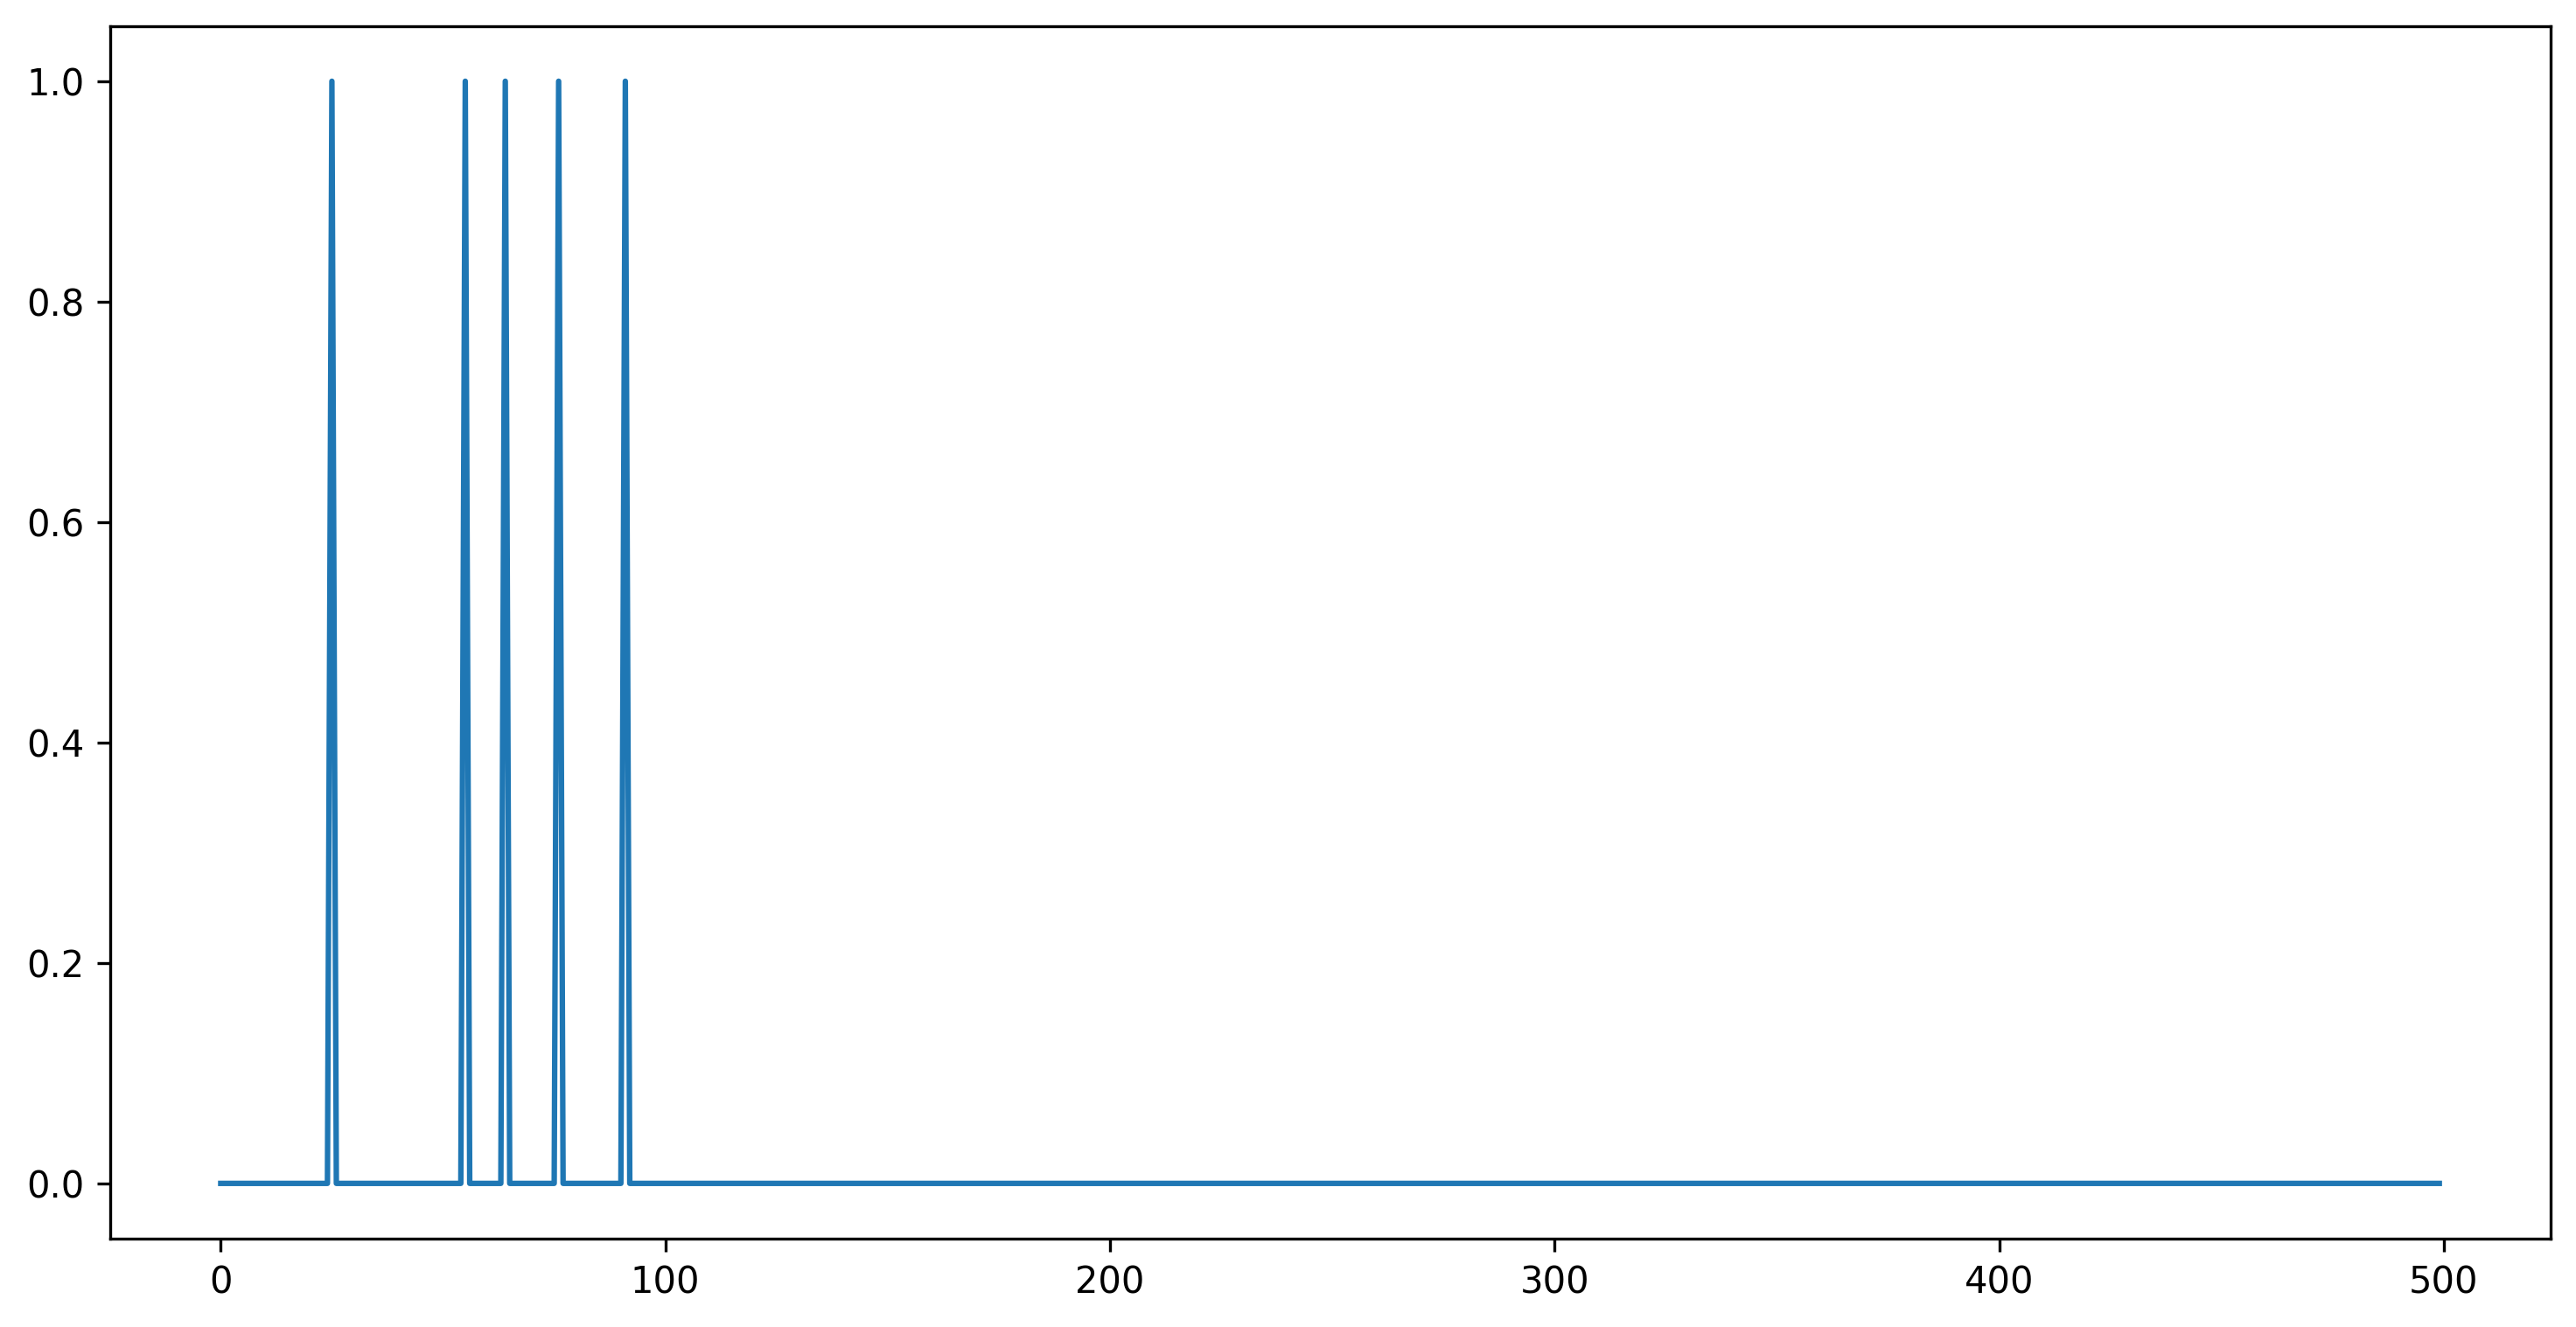

In [5]:
# - plot the output events
plt.plot(out.squeeze())

In [6]:
# - Let's look at the recorded state. What did we get back from the evolution?
rec_dict.keys()

dict_keys(['irec', 'spikes', 'isyn', 'vmem', 'U'])

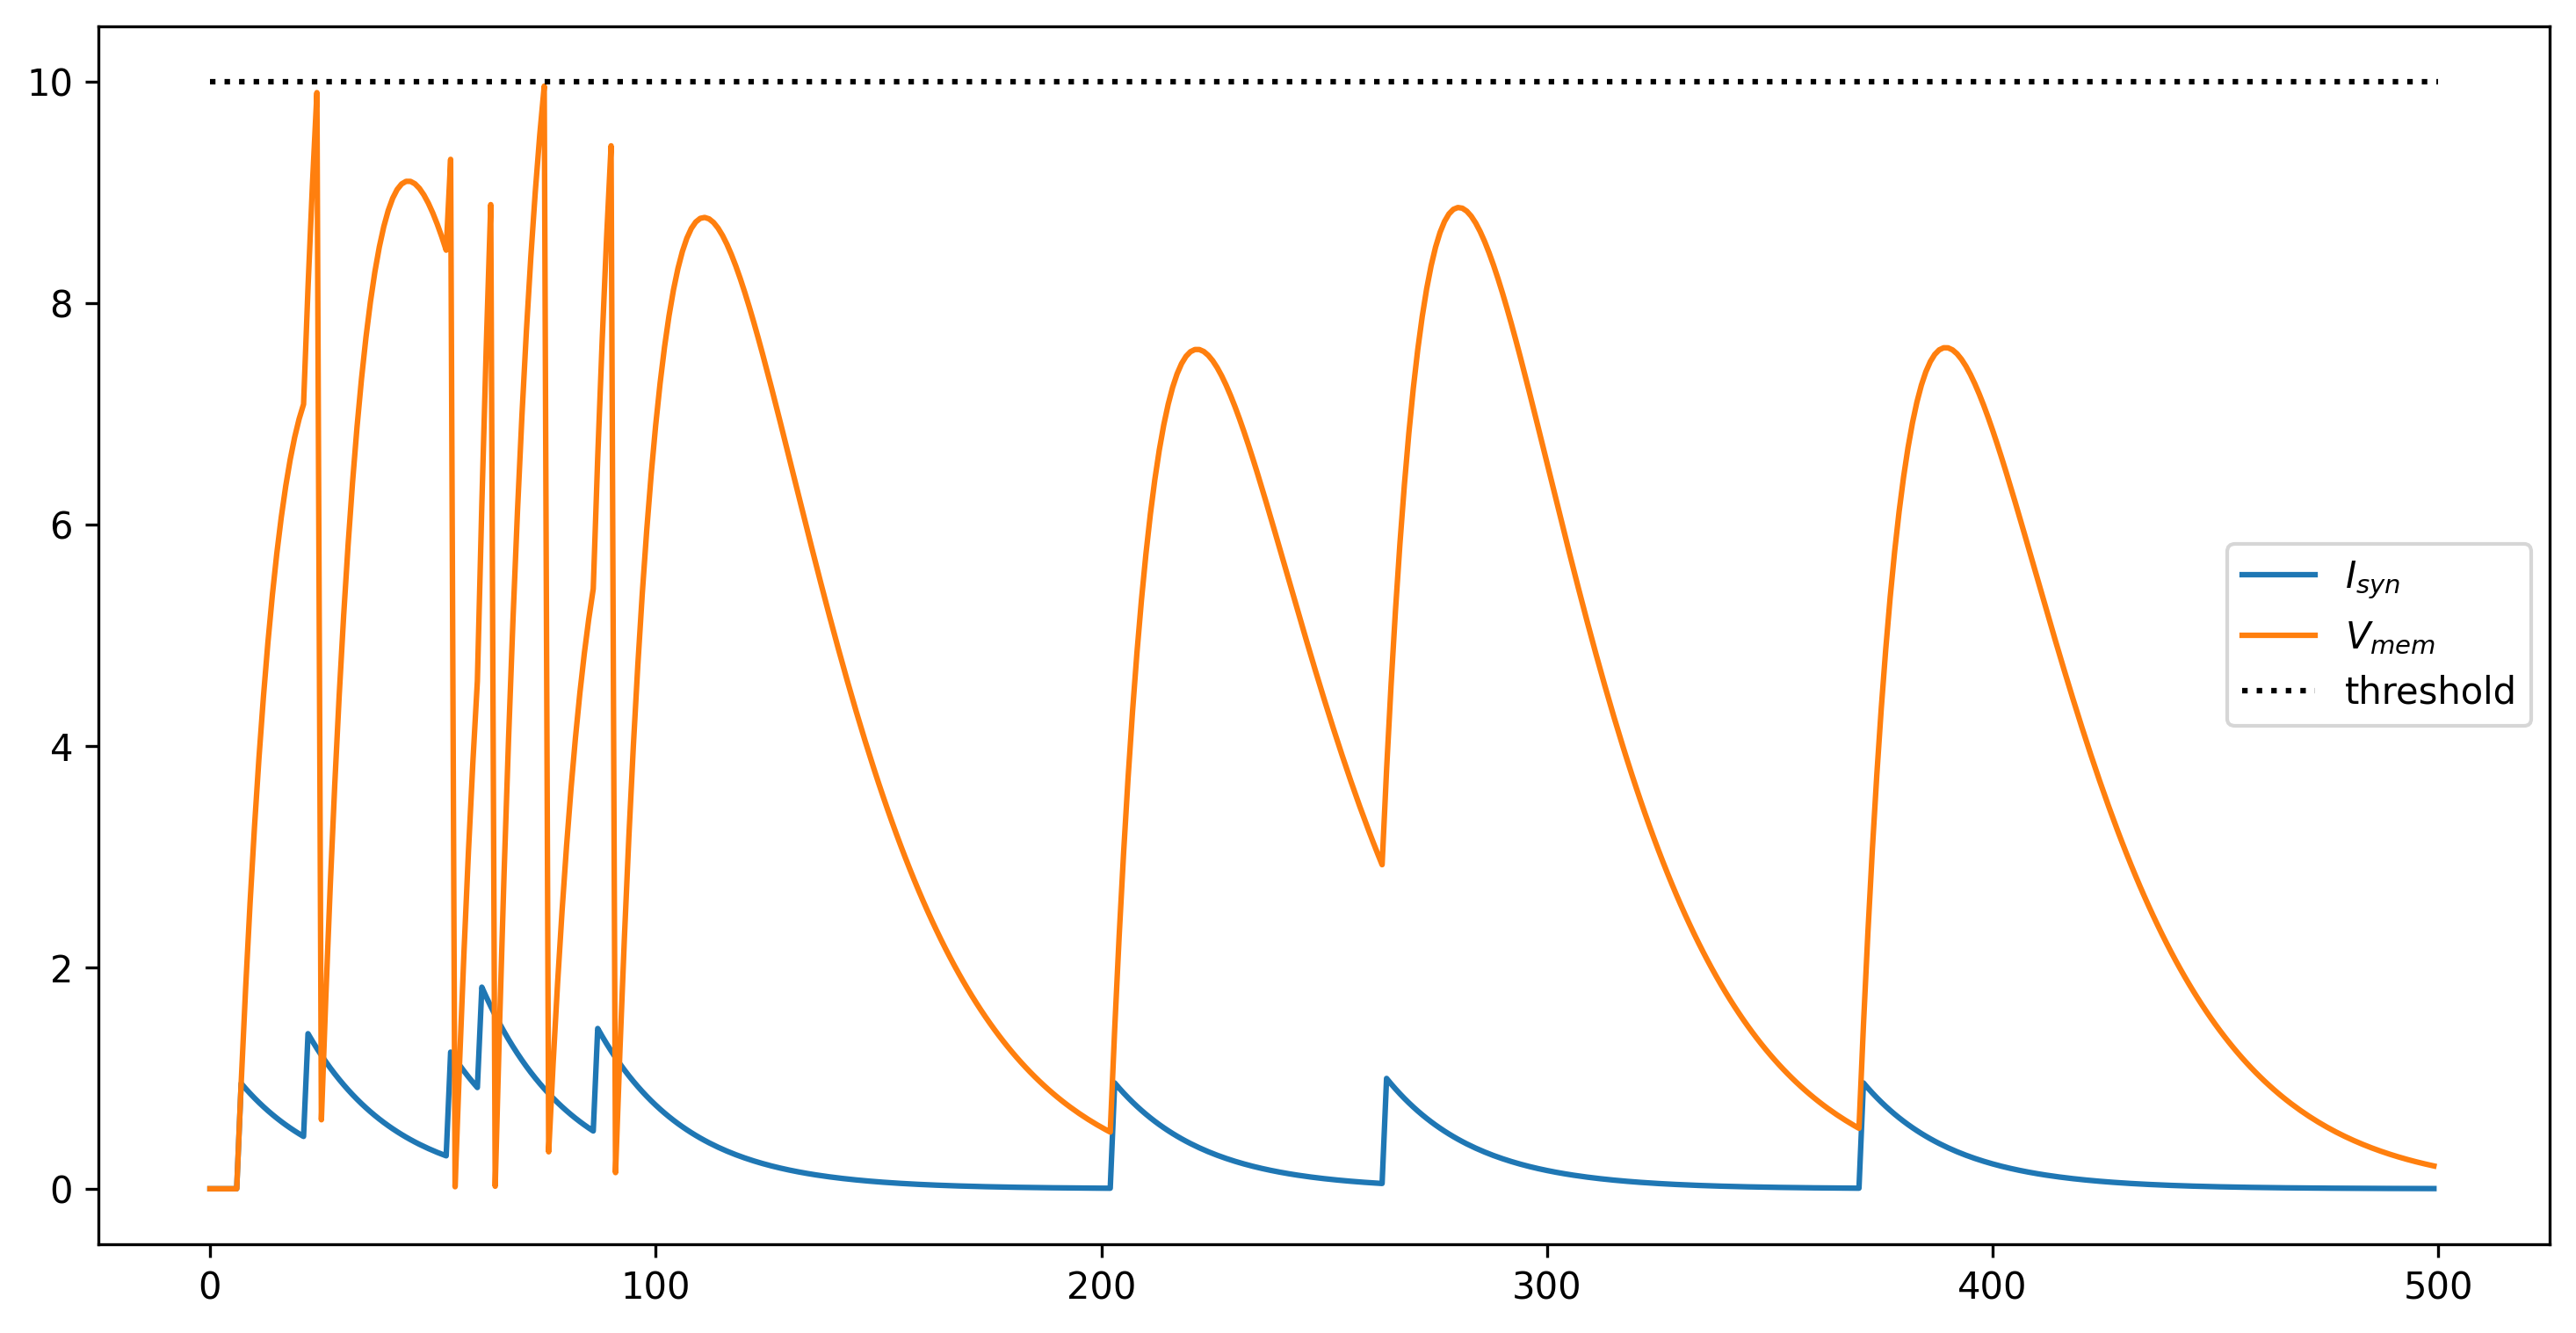

In [7]:
# - Let's plot the synaptic current `isyn` and membrane potential `vmem`
plt.plot(rec_dict['isyn'].squeeze(), label='$I_{syn}$')
plt.plot(rec_dict['vmem'].squeeze(), label='$V_{mem}$')
plt.plot([0, 500], [10, 10], 'k:', label='threshold')
plt.legend()

In [8]:
# - Rockpool modules all have a `state()` method which returns the internal module state
print(lif.state())

{'spikes': array([0.]), 'isyn': array([[0.00158838]]), 'vmem': array([0.20576466])}

In [9]:
# - Rockpool modules all have a `parameters()` method which returns the trainable parameters of a module
print(lif.parameters())

{'tau_mem': array([0.02]), 'tau_syn': array([[0.02]]), 'bias': array([0.]), 'threshold': array(10.)}

In [10]:
# - Rockpool modules all have a `simulation_parameters()` method which returns the non-trainable parameters
print(lif.simulation_parameters())

{'dt': 0.001, 'noise_std': 0.0, 'max_spikes_per_dt': 65536.0}

Obviously a single LIF neuron is not particularly useful. We need to be able to compose arbitrary network architectures. Now let's see how to build up a network in Rockpool.

We'll use a simple feed-forward network architecture here.

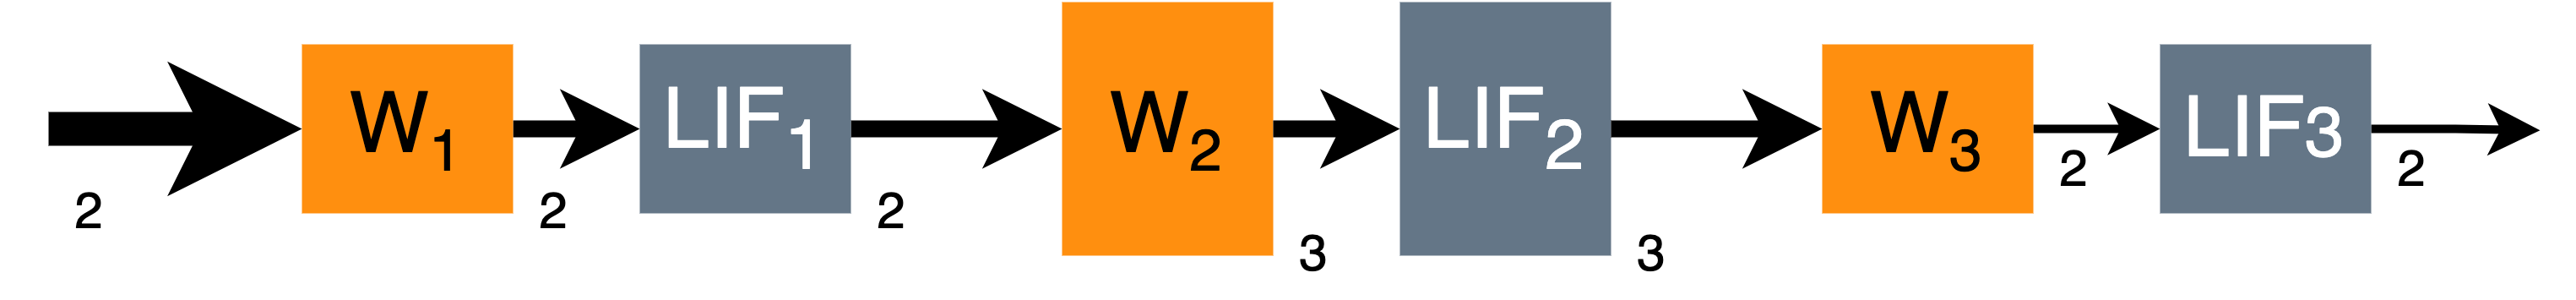

In [11]:
Image('images/network-layout-small.png')

In [12]:
# -  Import the required modules. `Linear` is a set of linear weights
from rockpool.nn.modules import Linear, LIF

# - `Sequential` is a combinator that puts modules in a sequence
from rockpool.nn.combinators import Sequential

In [13]:
# - We simply specify the modules in a sequence
net = Sequential(
    Linear((2, 3)),
    LIF(3),
    
    Linear((3, 3)),
    LIF(3),

    Linear((3, 2)),
    LIF(2),
)

print(net)

ModSequential  with shape (2, 2) {
    Linear '0_Linear' with shape (2, 3)
    LIF '1_LIF' with shape (3, 3)
    Linear '2_Linear' with shape (3, 3)
    LIF '3_LIF' with shape (3, 3)
    Linear '4_Linear' with shape (3, 2)
    LIF '5_LIF' with shape (2, 2)
}

In [14]:
# - The network itself is a module, with parameters, state, etc.
print(net.parameters())

{
    '0_Linear': {
        'weight': array([[-0.23809915, -0.84857766, -0.87173898],
       [ 1.24446722, -0.31155787, -0.93344889]])
    },
    '1_LIF': {
        'tau_mem': array([0.02, 0.02, 0.02]),
        'tau_syn': array([[0.02],
       [0.02],
       [0.02]]),
        'bias': array([0., 0., 0.]),
        'threshold': array([1., 1., 1.])
    },
    '2_Linear': {
        'weight': array([[ 0.2749353 , -0.35220755, -0.73241966],
       [-0.71654192,  0.36399566, -0.2762244 ],
       [ 0.92623096,  1.06190368,  0.41761431]])
    },
    '3_LIF': {
        'tau_mem': array([0.02, 0.02, 0.02]),
        'tau_syn': array([[0.02],
       [0.02],
       [0.02]]),
        'bias': array([0., 0., 0.]),
        'threshold': array([1., 1., 1.])
    },
    '4_Linear': {
        'weight': array([[-0.58495232, -0.15787585],
       [-0.62635013, -0.8591266 ],
       [-0.59812731, -0.20006263]])
    },
    '5_LIF': {
        'tau_mem': array([0.02, 0.02]),
        'tau_syn': array([[0.02],
       [0.02]]),
        'bias': array([0., 0.]),
        'threshold': array([1., 1.])
    }
}

In [15]:
print(net.state())

{
    '0_Linear': {},
    '1_LIF': {
        'spikes': array([0., 0., 0.]),
        'isyn': array([[0.],
       [0.],
       [0.]]),
        'vmem': array([0., 0., 0.])
    },
    '2_Linear': {},
    '3_LIF': {
        'spikes': array([0., 0., 0.]),
        'isyn': array([[0.],
       [0.],
       [0.]]),
        'vmem': array([0., 0., 0.])
    },
    '4_Linear': {},
    '5_LIF': {'spikes': array([0., 0.]), 'isyn': array([[0.],
       [0.]]), 'vmem': array([0., 0.])}
}

# BACK TO POWERPOINT for SHD intro

``tonic`` is a package for managing neuromorphic datasets (https://tonic.readthedocs.io)

We'll use tonic to download the Spiking Heidlberg Digits dataset (https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/), and provide a convenient python `torch`-like dataset.

``tonic`` also provides data transformations and caching.

In [16]:
# - Import tonic, download and import the SHD dataset
import tonic
train_data = tonic.datasets.SHD('./data')
shd_timestep = 1e-6
shd_channels = 700
shd_classes = 20

/Users/dylan/SynSense Dropbox/Dylan Muir/LiveSync/Development/Projects/onm_20230426/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


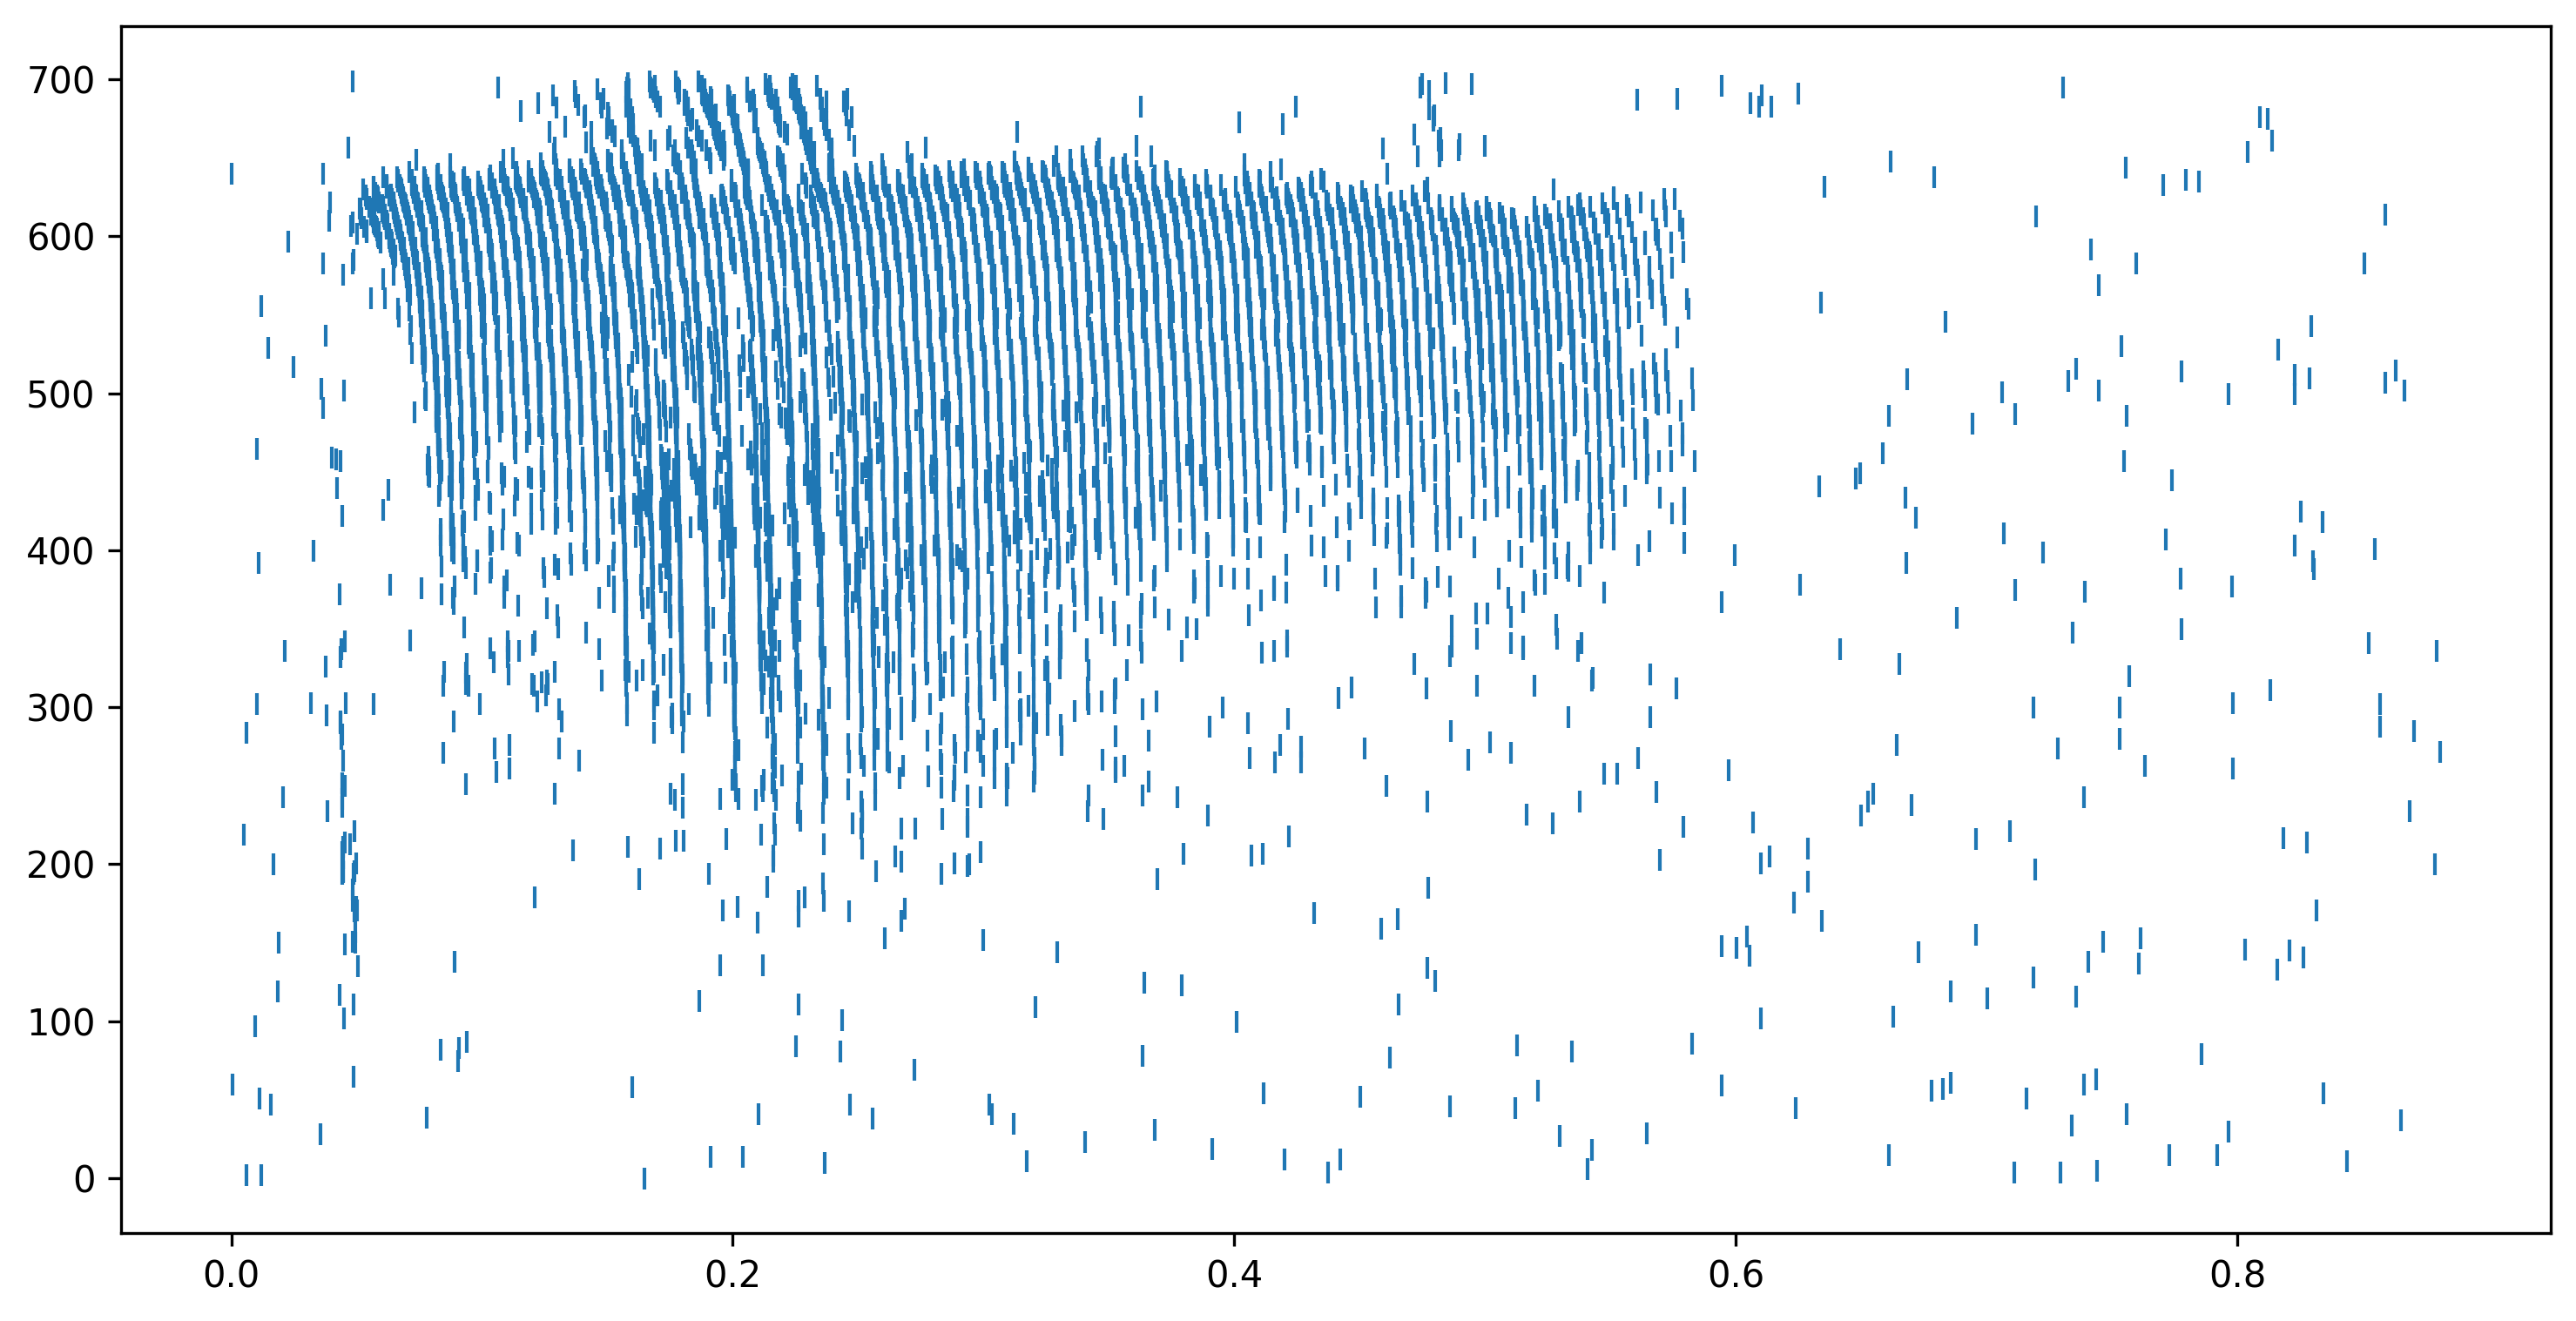

In [17]:
# - Let's examine one sample of the dataset
events, label = train_data[1]
times = events['t'] * shd_timestep
channels = events['x']
plt.plot(times, channels, '|')

In [18]:
# - We need to downsample the data to use it (to make the network and training simpler)
net_channels = 16
net_dt = 10e-3
sample_T = 250

In [19]:
# - We'll use `tonic` to downsample the data, using a transformation pipeline

import tonic.transforms as T

transform = T.Compose([
    # - Downsample in time and space
    T.Downsample(
        time_factor=shd_timestep / net_dt,
        spatial_factor=net_channels / shd_channels
        ),

    # - Rasterise the events
    T.ToFrame(
        sensor_size=(net_channels, 1, 1), time_window=1
    ),
    
    # - Convert to a tensor
    torch.Tensor,

    # - Make sure the samples are not too long in time
    lambda m: torch.squeeze(m)[:sample_T, :],
])

In [20]:
# - Reload the dataset with these transformations
train_data = tonic.datasets.SHD('./data', transform=transform)

In [21]:
# - Get one training sample
raster, label = train_data[1]

# - Extract spike times
times, channels = torch.where(raster)

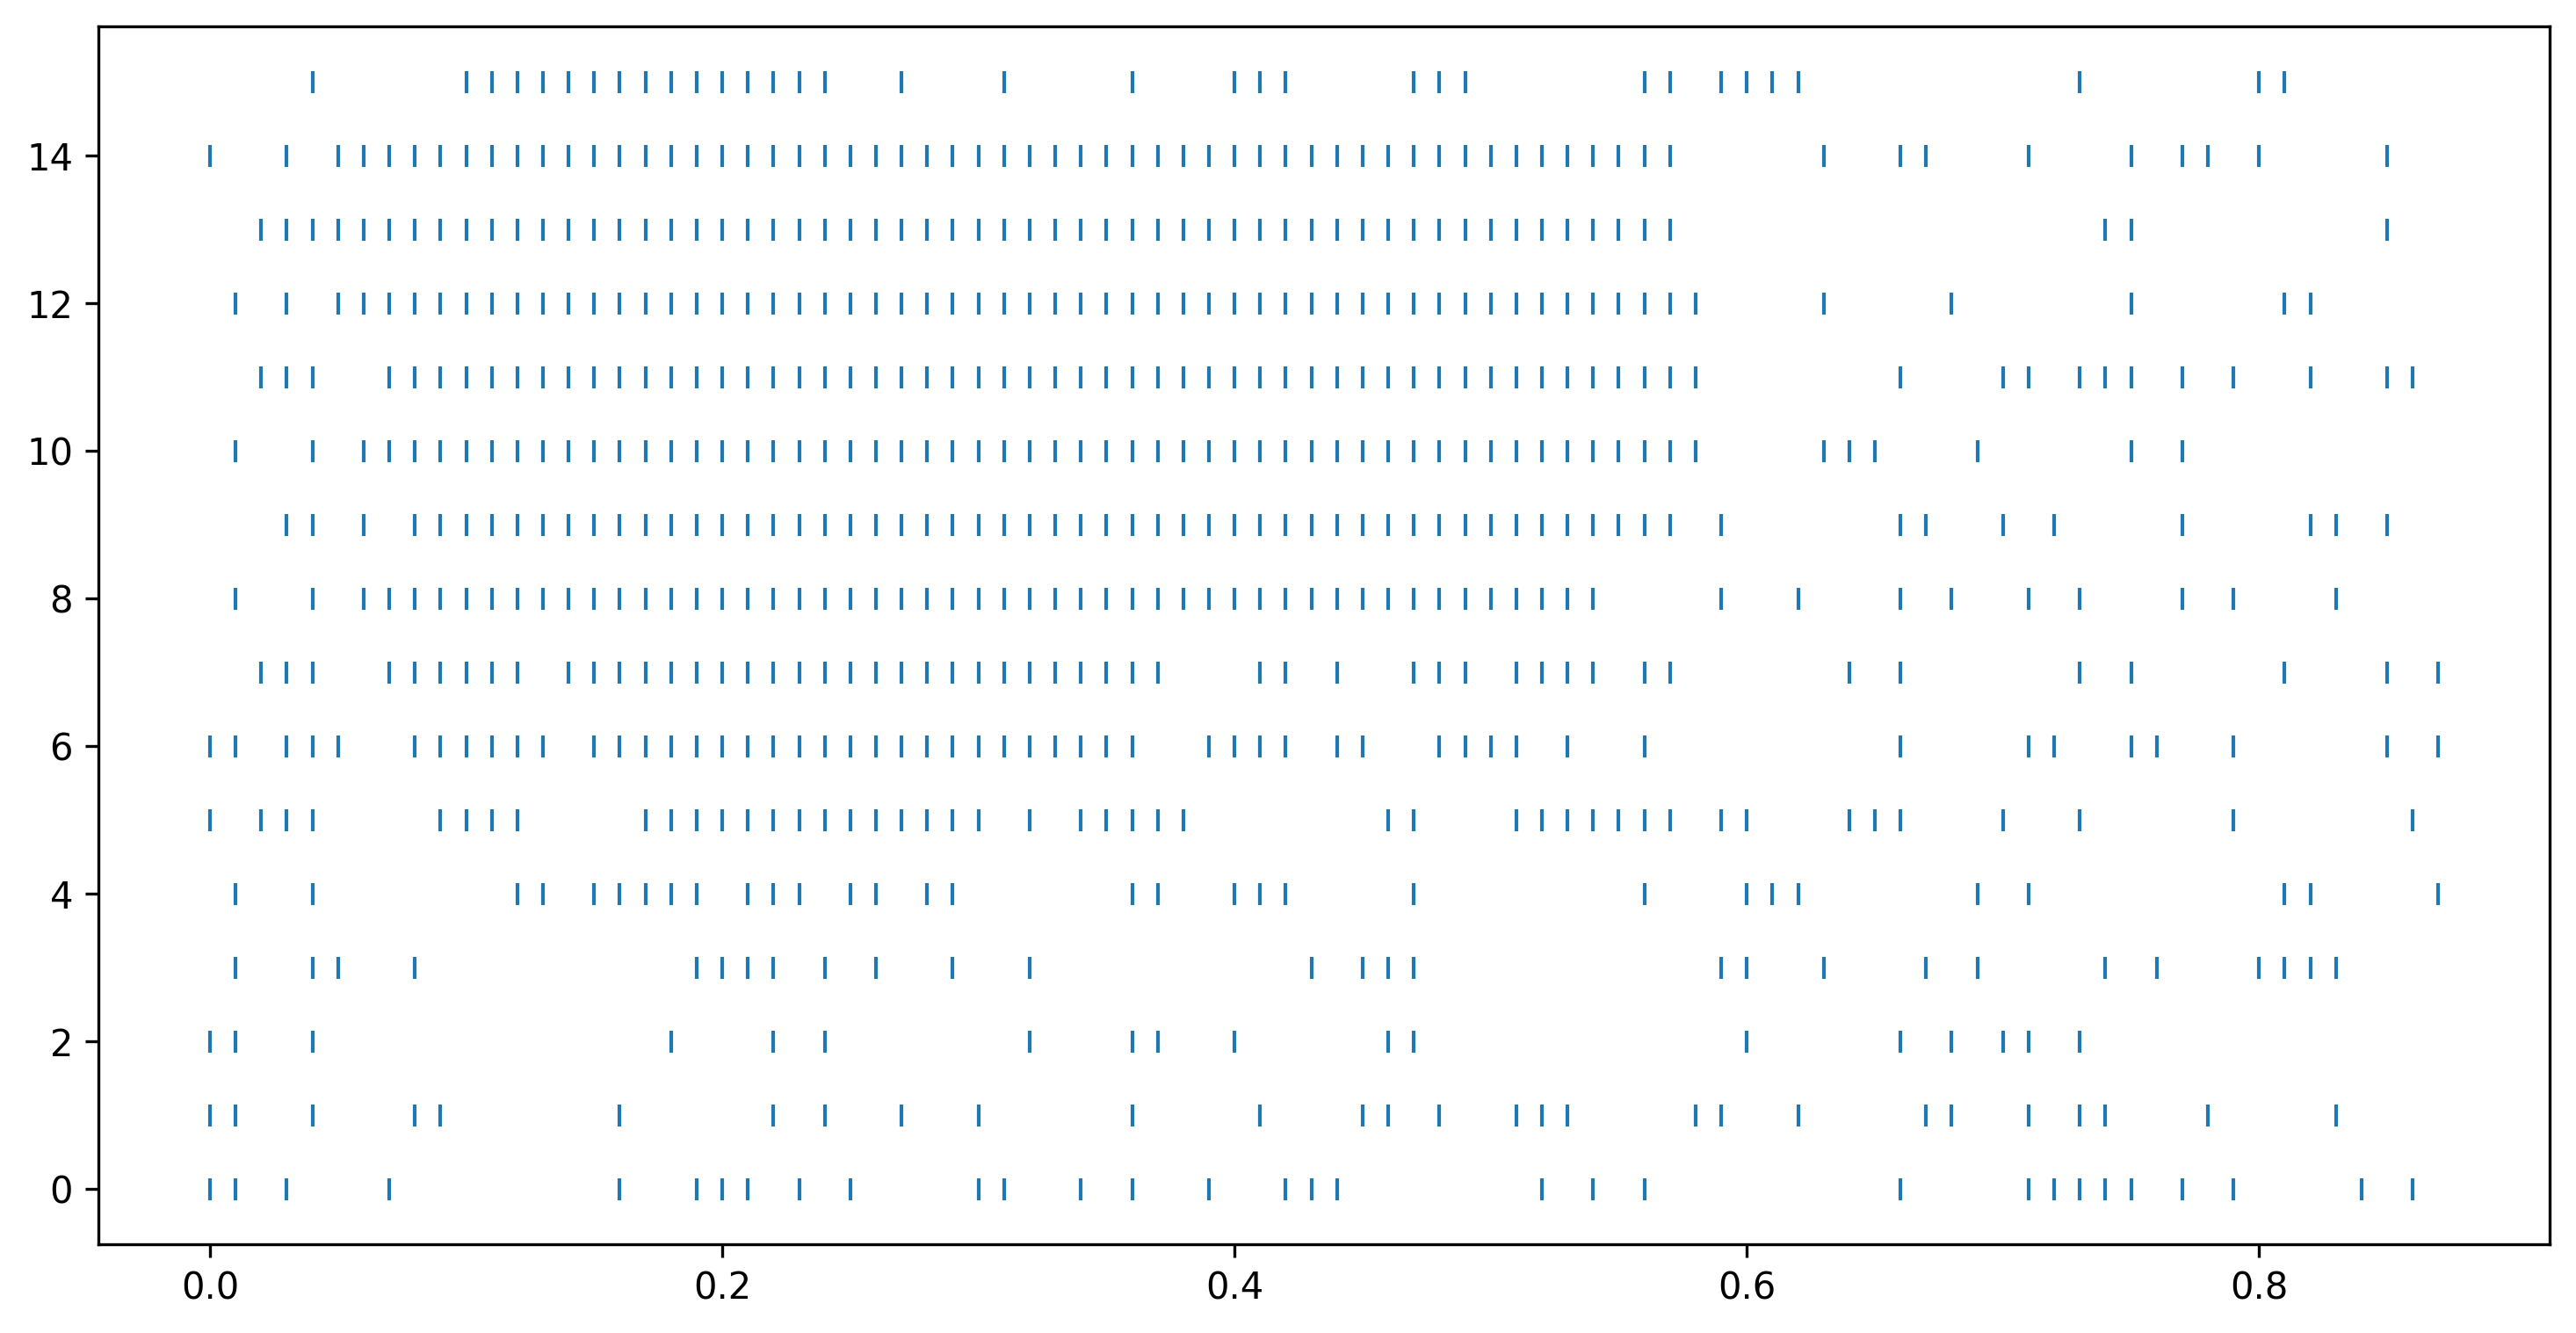

In [22]:
# - Plot this sample
plt.plot(times * net_dt, channels, '|')

Now we create a data loader to use in training. This is a standard `torch` dtaa loader, so I'm going to gloss over this cell.

We will select only the first 8 class labels to use, since Xylo only supports 8 output channels.

We will creata a data loader, using ``tonic`` to provide disk caching of the data. In-memory caching is also supported by ``tonic``, but not used here.

In [23]:
# - Create a class which subsets a dataset to a list of matching labels
class SubsetClasses(torch.utils.data.Dataset):
    def __init__(self,
                 dataset,
                 match_labels,
                 ):
        indices = []
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            if label in match_labels:
                indices.append(idx)

        self._subset_ds = torch.utils.data.Subset(dataset, indices)
        self._len = len(indices)

    def __getitem__(self, index):
        return self._subset_ds[index]
    
    def __len__(self):
        return self._len

In [24]:
# - Define arguments for the data loader
dataloader_kwargs = dict(
    batch_size=128,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=tonic.collation.PadTensors(batch_first=True),
    num_workers=0,
)

# - Create the data loader, using `tonic` to provide a disk cache
train_dl = torch.utils.data.DataLoader(
    tonic.DiskCachedDataset(
        dataset=SubsetClasses(train_data, range(8)),
        cache_path=f"cache/{train_data.__class__.__name__}/train/{net_channels}/{net_dt}",
        reset_cache = False,
    ),
    **dataloader_kwargs
)

Now we'll define and train an SNN for the SHD task, to deploy to Xylo. We'll use the ``torch`` backend of Rockpool, which uses the PyTorch automatic differentiation pipeline to train NNs.

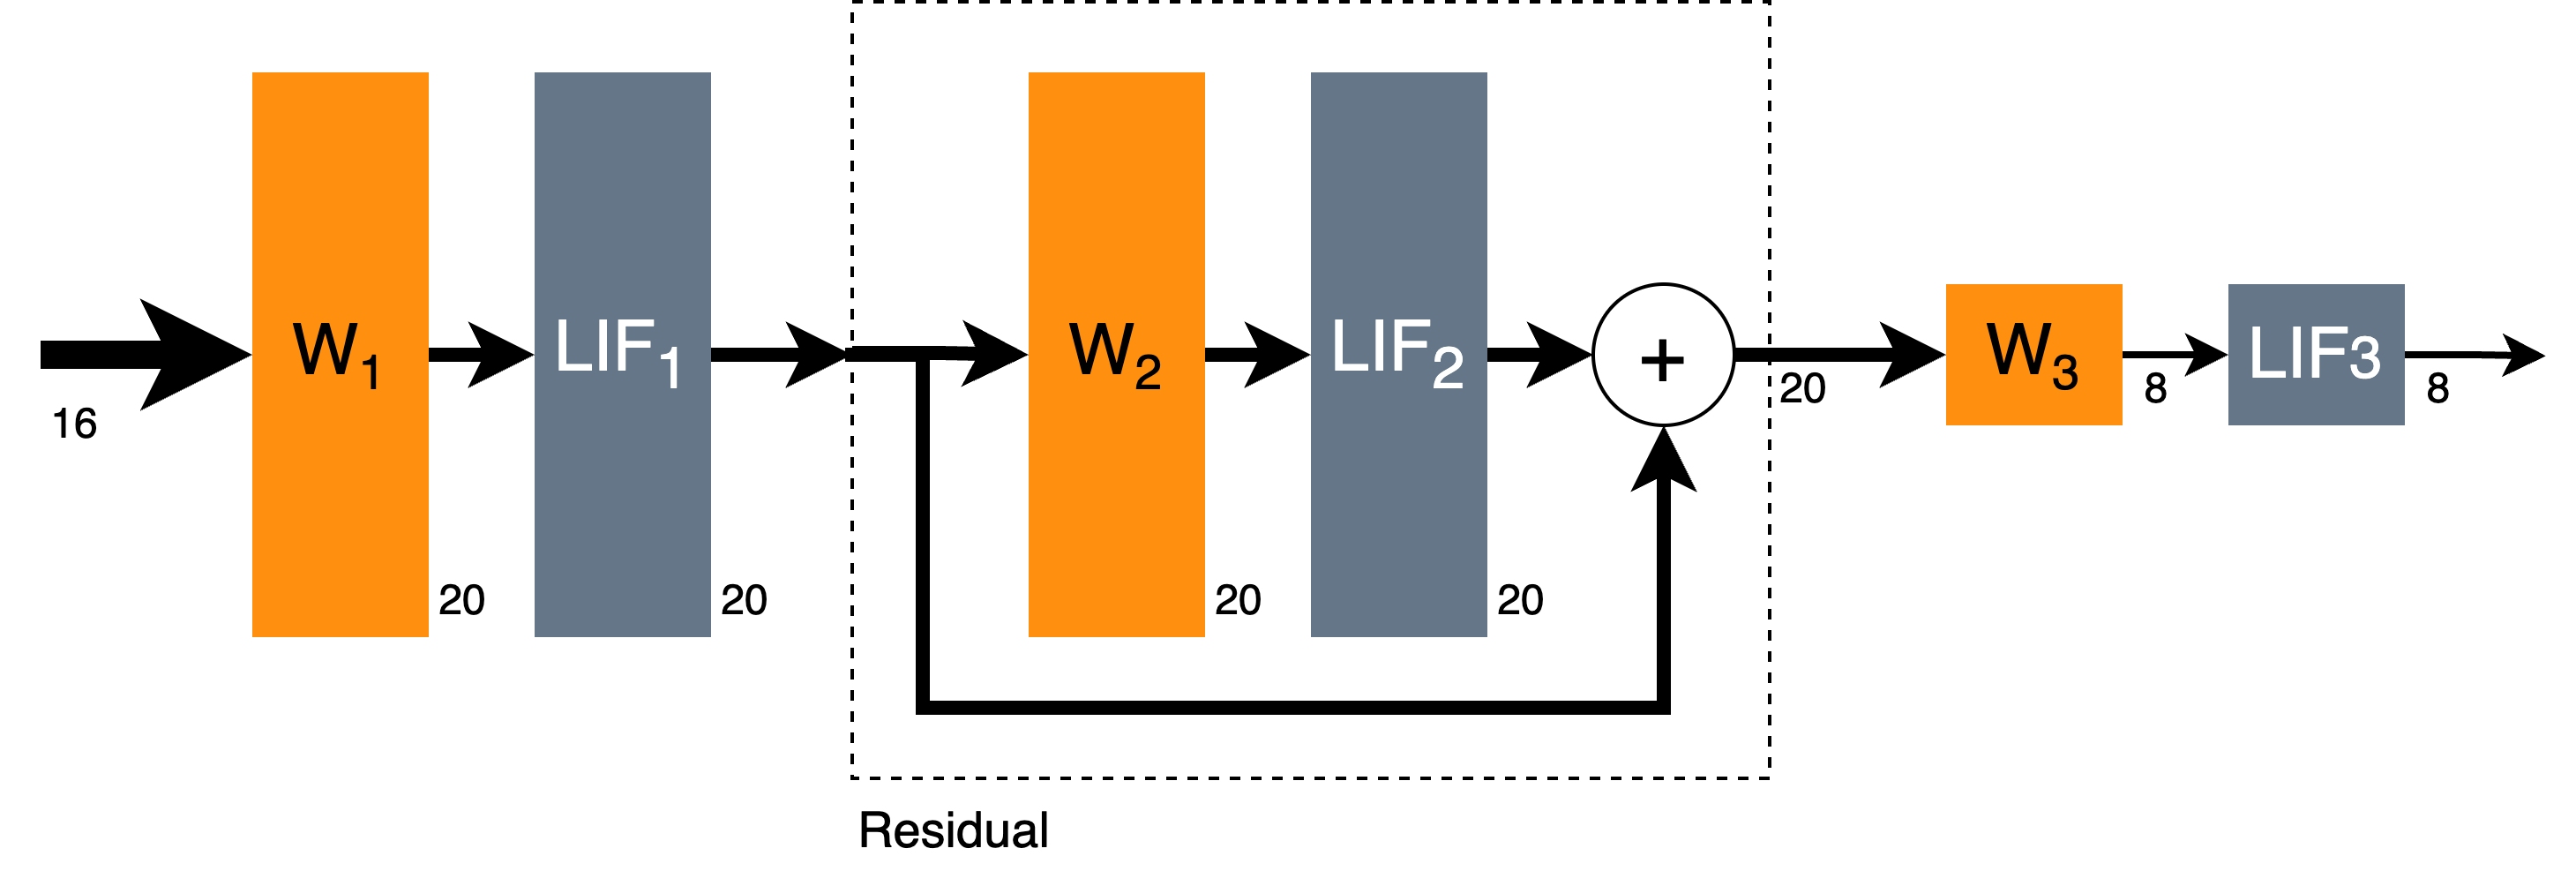

In [25]:
# - Show an image of the target network architecture
Image('images/network-layout-shd.svg.png')

In [26]:
# - Import the required torch-backed modules and combinators
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

# - Define a simple network architecture
Nin = net_channels
Nhid = 20
Nout = 8

net = Sequential(
    LinearTorch((Nin, Nhid)),
    LIFTorch(Nhid),

    Residual(
        LinearTorch((Nhid, Nhid)),
        LIFTorch(Nhid),
    ),

    LinearTorch((Nhid, Nout)),
    LIFTorch(Nout),
)
print(net)

TorchSequential  with shape (16, 8) {
    LinearTorch '0_LinearTorch' with shape (16, 20)
    LIFTorch '1_LIFTorch' with shape (20, 20)
    TorchResidual '2_TorchResidual' with shape (20, 20) {
        LinearTorch '0_LinearTorch' with shape (20, 20)
        LIFTorch '1_LIFTorch' with shape (20, 20)
    }
    LinearTorch '3_LinearTorch' with shape (20, 8)
    LIFTorch '4_LIFTorch' with shape (8, 8)
}

In [27]:
# - By default all parameters are trainable
print(net.parameters())

{
    '0_LinearTorch': {
        'weight': Parameter containing:
tensor([[ 0.2589,  0.5100, -0.1074,  0.1251, -0.3737, -0.4577, -0.3798,  0.3619,
         -0.2210,  0.1478, -0.3213, -0.1356,  0.4492, -0.3051, -0.3545, -0.4421,
         -0.6107, -0.4292,  0.3050,  0.5082],
        [ 0.0227,  0.0955, -0.4043, -0.1140, -0.4646, -0.0212,  0.4993, -0.2710,
          0.0420,  0.5751, -0.1198, -0.2365,  0.4085,  0.1835, -0.1181,  0.2489,
          0.4482,  0.2219, -0.1975,  0.3371],
        [-0.1697,  0.5109,  0.4579, -0.2850, -0.4267,  0.0869, -0.2207, -0.1225,
          0.4558,  0.0733, -0.3175,  0.6111,  0.5568, -0.0089, -0.0622, -0.5450,
         -0.2878,  0.0045,  0.4789, -0.4683],
        [-0.5037, -0.0634, -0.0257,  0.2714,  0.4722, -0.3917,  0.4587,  0.2546,
          0.0176, -0.0312, -0.5807, -0.5666, -0.2917, -0.5593,  0.2020,  0.0761,
          0.4369, -0.3509, -0.3894,  0.4234],
        [-0.0162, -0.5868, -0.3186, -0.1580,  0.2015, -0.4197, -0.3457, -0.4855,
         -0.5544, -0.4493, -0.2919, -0.1464,  0.2191,  0.6083, -0.3985,  0.3636,
          0.2963, -0.0644, -0.5029, -0.5191],
        [-0.4598,  0.2417, -0.2242, -0.4539, -0.5330, -0.5821, -0.3953,  0.2749,
         -0.0795,  0.5047,  0.1144, -0.0971, -0.1322, -0.3770, -0.2015, -0.5355,
          0.2336, -0.0727, -0.4503,  0.1301],
        [ 0.1465, -0.5256, -0.0543,  0.5866, -0.5740,  0.0460,  0.1042,  0.2589,
         -0.4775, -0.0424,  0.1598,  0.5263, -0.5735, -0.0509, -0.1625, -0.0020,
         -0.1050,  0.4272,  0.4175, -0.3363],
        [ 0.2928,  0.0674,  0.1632, -0.2107,  0.3269, -0.5595,  0.1017,  0.2566,
          0.3597, -0.1222, -0.2986, -0.5603,  0.4377, -0.0983, -0.3864, -0.5522,
         -0.0941,  0.4700, -0.3366,  0.3504],
        [ 0.3162, -0.5433, -0.5073, -0.2449, -0.2133,  0.5101,  0.1573,  0.2576,
          0.4019,  0.1232, -0.2643, -0.4074,  0.4437,  0.3755, -0.0029,  0.5148,
         -0.2294,  0.0341,  0.4477, -0.3215],
        [-0.5090,  0.3479,  0.5245,  0.1598, -0.4630, -0.3713,  0.4468,  0.1443,
         -0.3075, -0.1663,  0.2661, -0.3444,  0.4268, -0.5749,  0.2274,  0.1953,
         -0.2073,  0.1900,  0.1967,  0.1991],
        [ 0.4259, -0.0645, -0.0320, -0.0631,  0.2986, -0.1268, -0.3501,  0.1722,
          0.1831,  0.0073,  0.2691,  0.0328, -0.5077,  0.0140, -0.2915,  0.1599,
          0.1126,  0.1287,  0.2879,  0.5557],
        [-0.3834, -0.3429,  0.3822, -0.5031,  0.3903, -0.0373, -0.2362,  0.5781,
         -0.4020, -0.1605,  0.3067, -0.2021,  0.0980, -0.3246, -0.2245, -0.4536,
          0.2184,  0.2144, -0.5066, -0.0813],
        [-0.0823, -0.5184,  0.0290,  0.0939,  0.4987,  0.2313, -0.3783, -0.2362,
         -0.0438, -0.2319,  0.0593,  0.5899, -0.3272, -0.3250, -0.2467, -0.0084,
          0.0842,  0.5188,  0.2517, -0.5992],
        [ 0.2224, -0.3865, -0.5309,  0.3609, -0.4669, -0.3220, -0.5229,  0.3428,
          0.1950,  0.0192, -0.0599,  0.4124, -0.5310, -0.1582,  0.3267, -0.5203,
          0.3653, -0.5403, -0.0020,  0.3724],
        [-0.3562, -0.2590,  0.2013, -0.3187, -0.4750,  0.0765,  0.3499,  0.0503,
         -0.4689,  0.2791,  0.1978,  0.1937,  0.3097,  0.1323, -0.1540,  0.0828,
         -0.2365,  0.0344, -0.3735,  0.3889],
        [ 0.0951,  0.4935,  0.3404,  0.2192,  0.1280,  0.2022,  0.4074,  0.2726,
         -0.1065,  0.4481,  0.3733, -0.3183,  0.1496,  0.3366,  0.4084,  0.4506,
         -0.2108, -0.0072,  0.3286, -0.4151]], requires_grad=True)
    },
    '1_LIFTorch': {
        'tau_mem': Parameter containing:
tensor([0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200], requires_grad=True),
        'tau_syn': Parameter containing:
tensor([[0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
 

In [28]:
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

# - Import the `Constant` decorator, so we can specify non-trainable parameters
from rockpool.parameters import Constant

# - Define shared neuron parameters to use
neuron_parameters = {
    'tau_mem': Constant(50e-3),
    'tau_syn': Constant(20e-3),
    'bias': Constant(0.),
    'threshold': Constant(1.),
    'dt': net_dt,
}

# - Define the network with shared parameters
net = Sequential(
    LinearTorch((Nin, Nhid)),
    LIFTorch(Nhid, **neuron_parameters),

    Residual(
        LinearTorch((Nhid, Nhid)),
        LIFTorch(Nhid, **neuron_parameters),
    ),

    LinearTorch((Nhid, Nout)),
    LIFTorch(Nout, **neuron_parameters),
)

print(net)

TorchSequential  with shape (16, 8) {
    LinearTorch '0_LinearTorch' with shape (16, 20)
    LIFTorch '1_LIFTorch' with shape (20, 20)
    TorchResidual '2_TorchResidual' with shape (20, 20) {
        LinearTorch '0_LinearTorch' with shape (20, 20)
        LIFTorch '1_LIFTorch' with shape (20, 20)
    }
    LinearTorch '3_LinearTorch' with shape (20, 8)
    LIFTorch '4_LIFTorch' with shape (8, 8)
}

In [29]:
# - Now only weights are trainable
print(net.parameters())

{
    '0_LinearTorch': {
        'weight': Parameter containing:
tensor([[-0.4130, -0.1102, -0.0848, -0.4463,  0.1932, -0.1909, -0.1433,  0.2503,
          0.2530, -0.0799,  0.2489, -0.4999, -0.1101,  0.0237,  0.3529,  0.2511,
          0.3056,  0.2034,  0.4550,  0.2765],
        [ 0.3069, -0.3949,  0.6008,  0.2531, -0.3747,  0.5285, -0.2818, -0.2948,
          0.1763, -0.5033, -0.1038,  0.2656, -0.1911, -0.5157, -0.3364, -0.1603,
         -0.3378,  0.3723,  0.0075, -0.2225],
        [ 0.4545,  0.0017,  0.2753,  0.1333, -0.4755, -0.3846,  0.5521,  0.6054,
         -0.3769,  0.4519,  0.0064, -0.5035, -0.5509, -0.2085,  0.5741,  0.5112,
         -0.0084, -0.5353,  0.5666,  0.1109],
        [-0.2132,  0.1971, -0.4620,  0.5310, -0.2839, -0.1683,  0.2904,  0.0987,
          0.3535, -0.4627, -0.5929, -0.3532, -0.5789, -0.2305, -0.3609, -0.4889,
          0.1842, -0.5986,  0.2337, -0.4273],
        [-0.1280, -0.5683, -0.3675, -0.2959, -0.4307,  0.0629, -0.1107,  0.3003,
         -0.1386, -0.0914,  0.5851,  0.3286, -0.1559, -0.1034, -0.4118, -0.2119,
         -0.1497,  0.2578,  0.1085,  0.0581],
        [ 0.5256, -0.2383, -0.3635,  0.0177,  0.3729,  0.3339, -0.1654,  0.3966,
          0.2842,  0.2919, -0.4749, -0.1309,  0.0470,  0.2249,  0.0238, -0.3507,
         -0.0137, -0.1187, -0.3121, -0.3052],
        [-0.4823, -0.0246, -0.4685,  0.3187, -0.2542, -0.5657, -0.5719,  0.5553,
         -0.3215,  0.0565, -0.3940, -0.5976,  0.1517,  0.3042, -0.2239, -0.4554,
          0.3289,  0.5202, -0.3456,  0.0268],
        [ 0.1491,  0.0892, -0.0733, -0.3810,  0.4829, -0.4959,  0.5854, -0.5817,
         -0.1669,  0.3210, -0.4152, -0.0363, -0.4121,  0.1127,  0.4518,  0.0838,
          0.3655,  0.0930, -0.4362,  0.5612],
        [-0.1114,  0.5925, -0.1625, -0.2709,  0.1621, -0.1961, -0.3411,  0.2436,
         -0.3193,  0.2862,  0.3182,  0.1381, -0.2788, -0.5673,  0.1051, -0.2004,
         -0.5516, -0.5017,  0.4982, -0.0075],
        [ 0.0662,  0.0056, -0.1706,  0.1425,  0.0351, -0.4782, -0.2305,  0.3030,
          0.4407,  0.3121, -0.3664, -0.2952,  0.4747, -0.1367, -0.4563, -0.5404,
         -0.1623, -0.4400,  0.0399, -0.2604],
        [-0.4514,  0.4357, -0.1633,  0.2155, -0.4329,  0.5594, -0.5168, -0.3519,
         -0.4064, -0.0273,  0.0702, -0.2948,  0.2122,  0.2771, -0.4749,  0.1275,
          0.1663, -0.2973,  0.1599,  0.2643],
        [ 0.2377, -0.2943,  0.4968, -0.3110, -0.5825, -0.5754, -0.1525,  0.2328,
          0.5078, -0.2654,  0.1840,  0.3282,  0.0868, -0.3362, -0.1298, -0.4672,
         -0.4301,  0.4907,  0.4574, -0.2916],
        [-0.1936,  0.0868,  0.2954,  0.5688,  0.0596,  0.5509,  0.5490, -0.1781,
         -0.1292,  0.4019,  0.4270, -0.1325, -0.1872,  0.6110,  0.5824,  0.2511,
         -0.1055,  0.2639,  0.4593, -0.2295],
        [-0.5135,  0.1743,  0.5161,  0.4562, -0.4847,  0.5093, -0.2740, -0.0601,
          0.2930,  0.0530, -0.4802, -0.0124,  0.0443, -0.3168, -0.2277,  0.4750,
         -0.2128,  0.1808, -0.1450,  0.0154],
        [ 0.5348, -0.3568,  0.1942, -0.0191, -0.2887,  0.2652, -0.4621, -0.5543,
          0.4470,  0.5872,  0.0447, -0.4129,  0.6096, -0.2377,  0.1939, -0.1430,
         -0.2923, -0.3948, -0.5707,  0.1292],
        [-0.3913, -0.2574, -0.2682,  0.2409, -0.2883, -0.4121,  0.2604, -0.4568,
         -0.3999, -0.0213, -0.3431,  0.5118, -0.5386, -0.3054, -0.1828, -0.2548,
         -0.1695, -0.4824,  0.3456, -0.0980]], requires_grad=True)
    },
    '1_LIFTorch': {},
    '2_TorchResidual': {
        '0_LinearTorch': {
            'weight': Parameter containing:
tensor([[-0.2897, -0.4713,  0.5448,  0.3642, -0.3349, -0.1484, -0.3642,  0.1433,
          0.2564, -0.4239,  0.0163,  0.4449,  0.1863,  0.0404,  0.4171,  0.2246,
          0.2819, -0.3272,  0.1595,  0.3933],
        [ 0.5430, -0.0748, -0.1263,  0.3684, -0.4855, -0.2054,  0.1001,  0.1568,
         -0.0504,  0.0887, -0.1851, -0.3336,  0.2150, -0.1217, -0.4146, -0.1949,
         -0.3062,  0.3948,  0.1982,  0.1816],
        [ 0.5183,  0.2931,  0.3856, -0.0858, 

In [30]:
# - Import optimizer and loss function from pytorch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# - Get the optimiser functions
optimizer = Adam(net.parameters().astorch(), lr=1e-3)

# - Loss function
loss_fun = CrossEntropyLoss()

In [31]:
train_net = False

if train_net:
    # - Training Loop
    num_epochs = 10
    for e in range(num_epochs):

        # - Loop over dataset, getting batches
        for events, labels in train_dl:
            # - Zero the optimizer gradients
            optimizer.zero_grad()

            # - Evolve the network with this batch
            output, _, _ = net(events)

            # - Get the prediction -- number of spikes in each channel
            pred = torch.sum(output, dim=1)

            # - Get the loss value for this batch
            loss = loss_fun(pred, labels)
            
            # - Compute gradients with backward step and update parameters
            loss.backward()
            optimizer.step()

        # - Print the current loss
        print(f'Epoch {e}/{num_epochs}, loss {loss.item():.2e}')

In [32]:
# - Load a pre-trained version
net.load('pretrained-37ke.json')

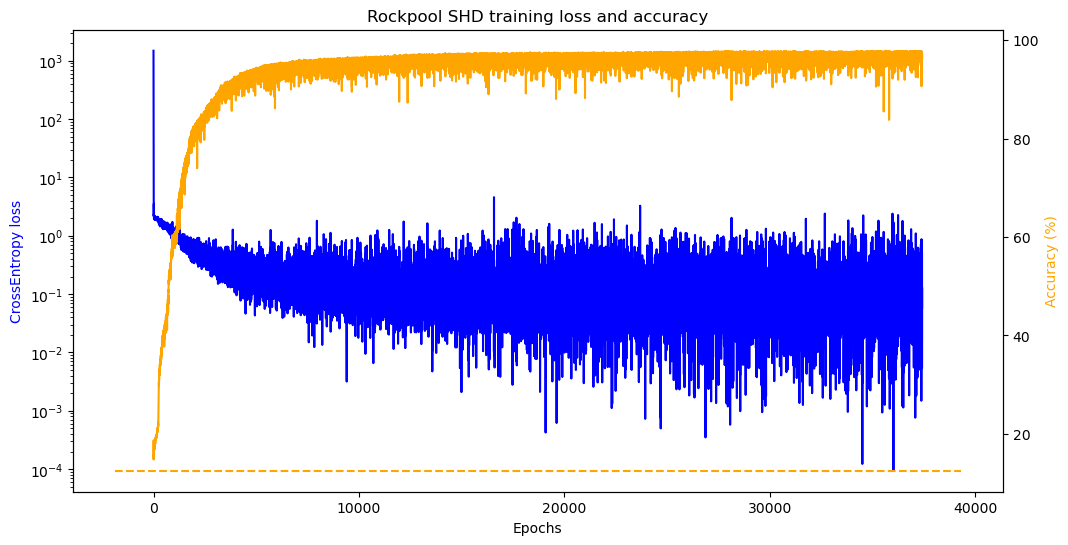

In [33]:
# - Plot the loss curve over training this pre-trained version
Image('loss-pretrained-37ke.png')

In [34]:
# - Evolve the trained network over a training sample
events, label = train_data[2]
out, _, rd = net(events, record = True)

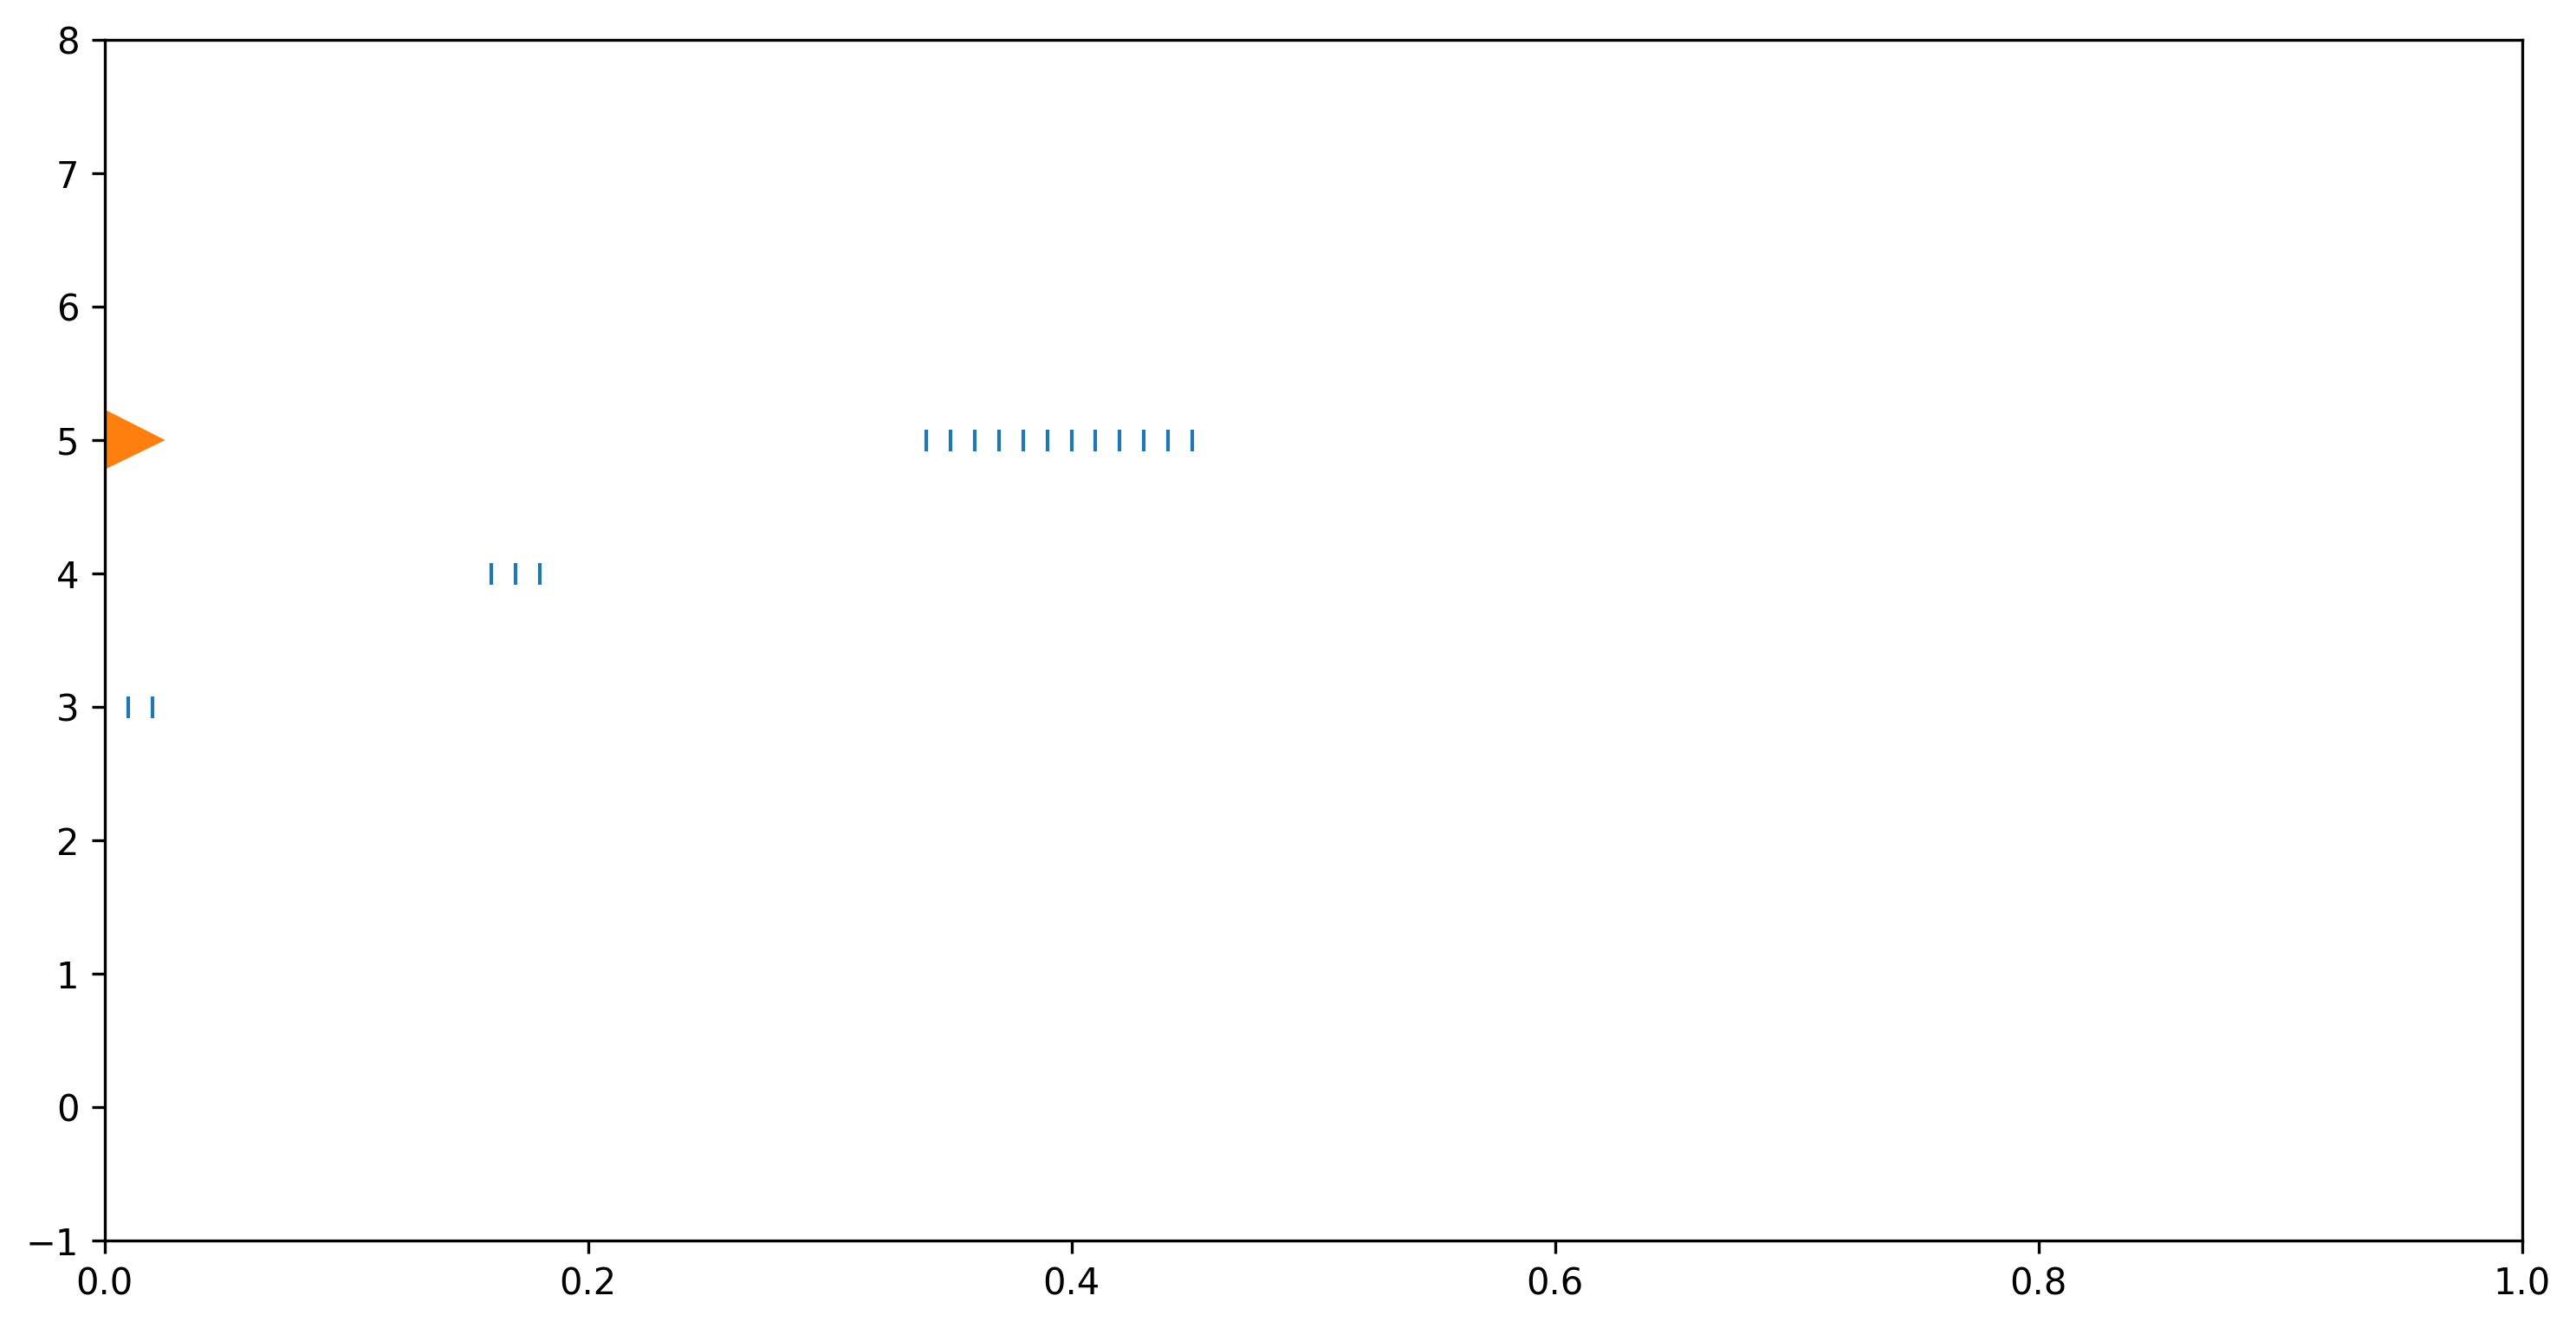

In [35]:
# - Plot the output of the network
times, channels = torch.where(out[0])
plt.plot(times * net_dt, channels, '|')

# - Indicate the target label
plt.plot(0.01, label, '>', ms=18)
plt.ylim([-1, 8])
plt.xlim([0, 1.]);

# BACK TO POWERPOINT to describe Xylo architecture

In [36]:
# - Extract a serialised computational graph from the network
net.as_graph()

GraphHolder "TorchSequential__11445185328" with 16 input nodes -> 8 output nodes

In [37]:
# - Now we need to map and quantise
import rockpool.devices.xylo.syns61201 as xylo

# - Use the `mapper` function to convert the network architecture
spec = xylo.mapper(net.as_graph())
print(spec.keys())

dict_keys(['mapped_graph', 'weights_in', 'weights_out', 'weights_rec', 'dash_mem', 'dash_mem_out', 'dash_syn', 
'dash_syn_2', 'dash_syn_out', 'threshold', 'threshold_out', 'bias', 'bias_out', 'weight_shift_in', 
'weight_shift_rec', 'weight_shift_out', 'aliases', 'dt'])

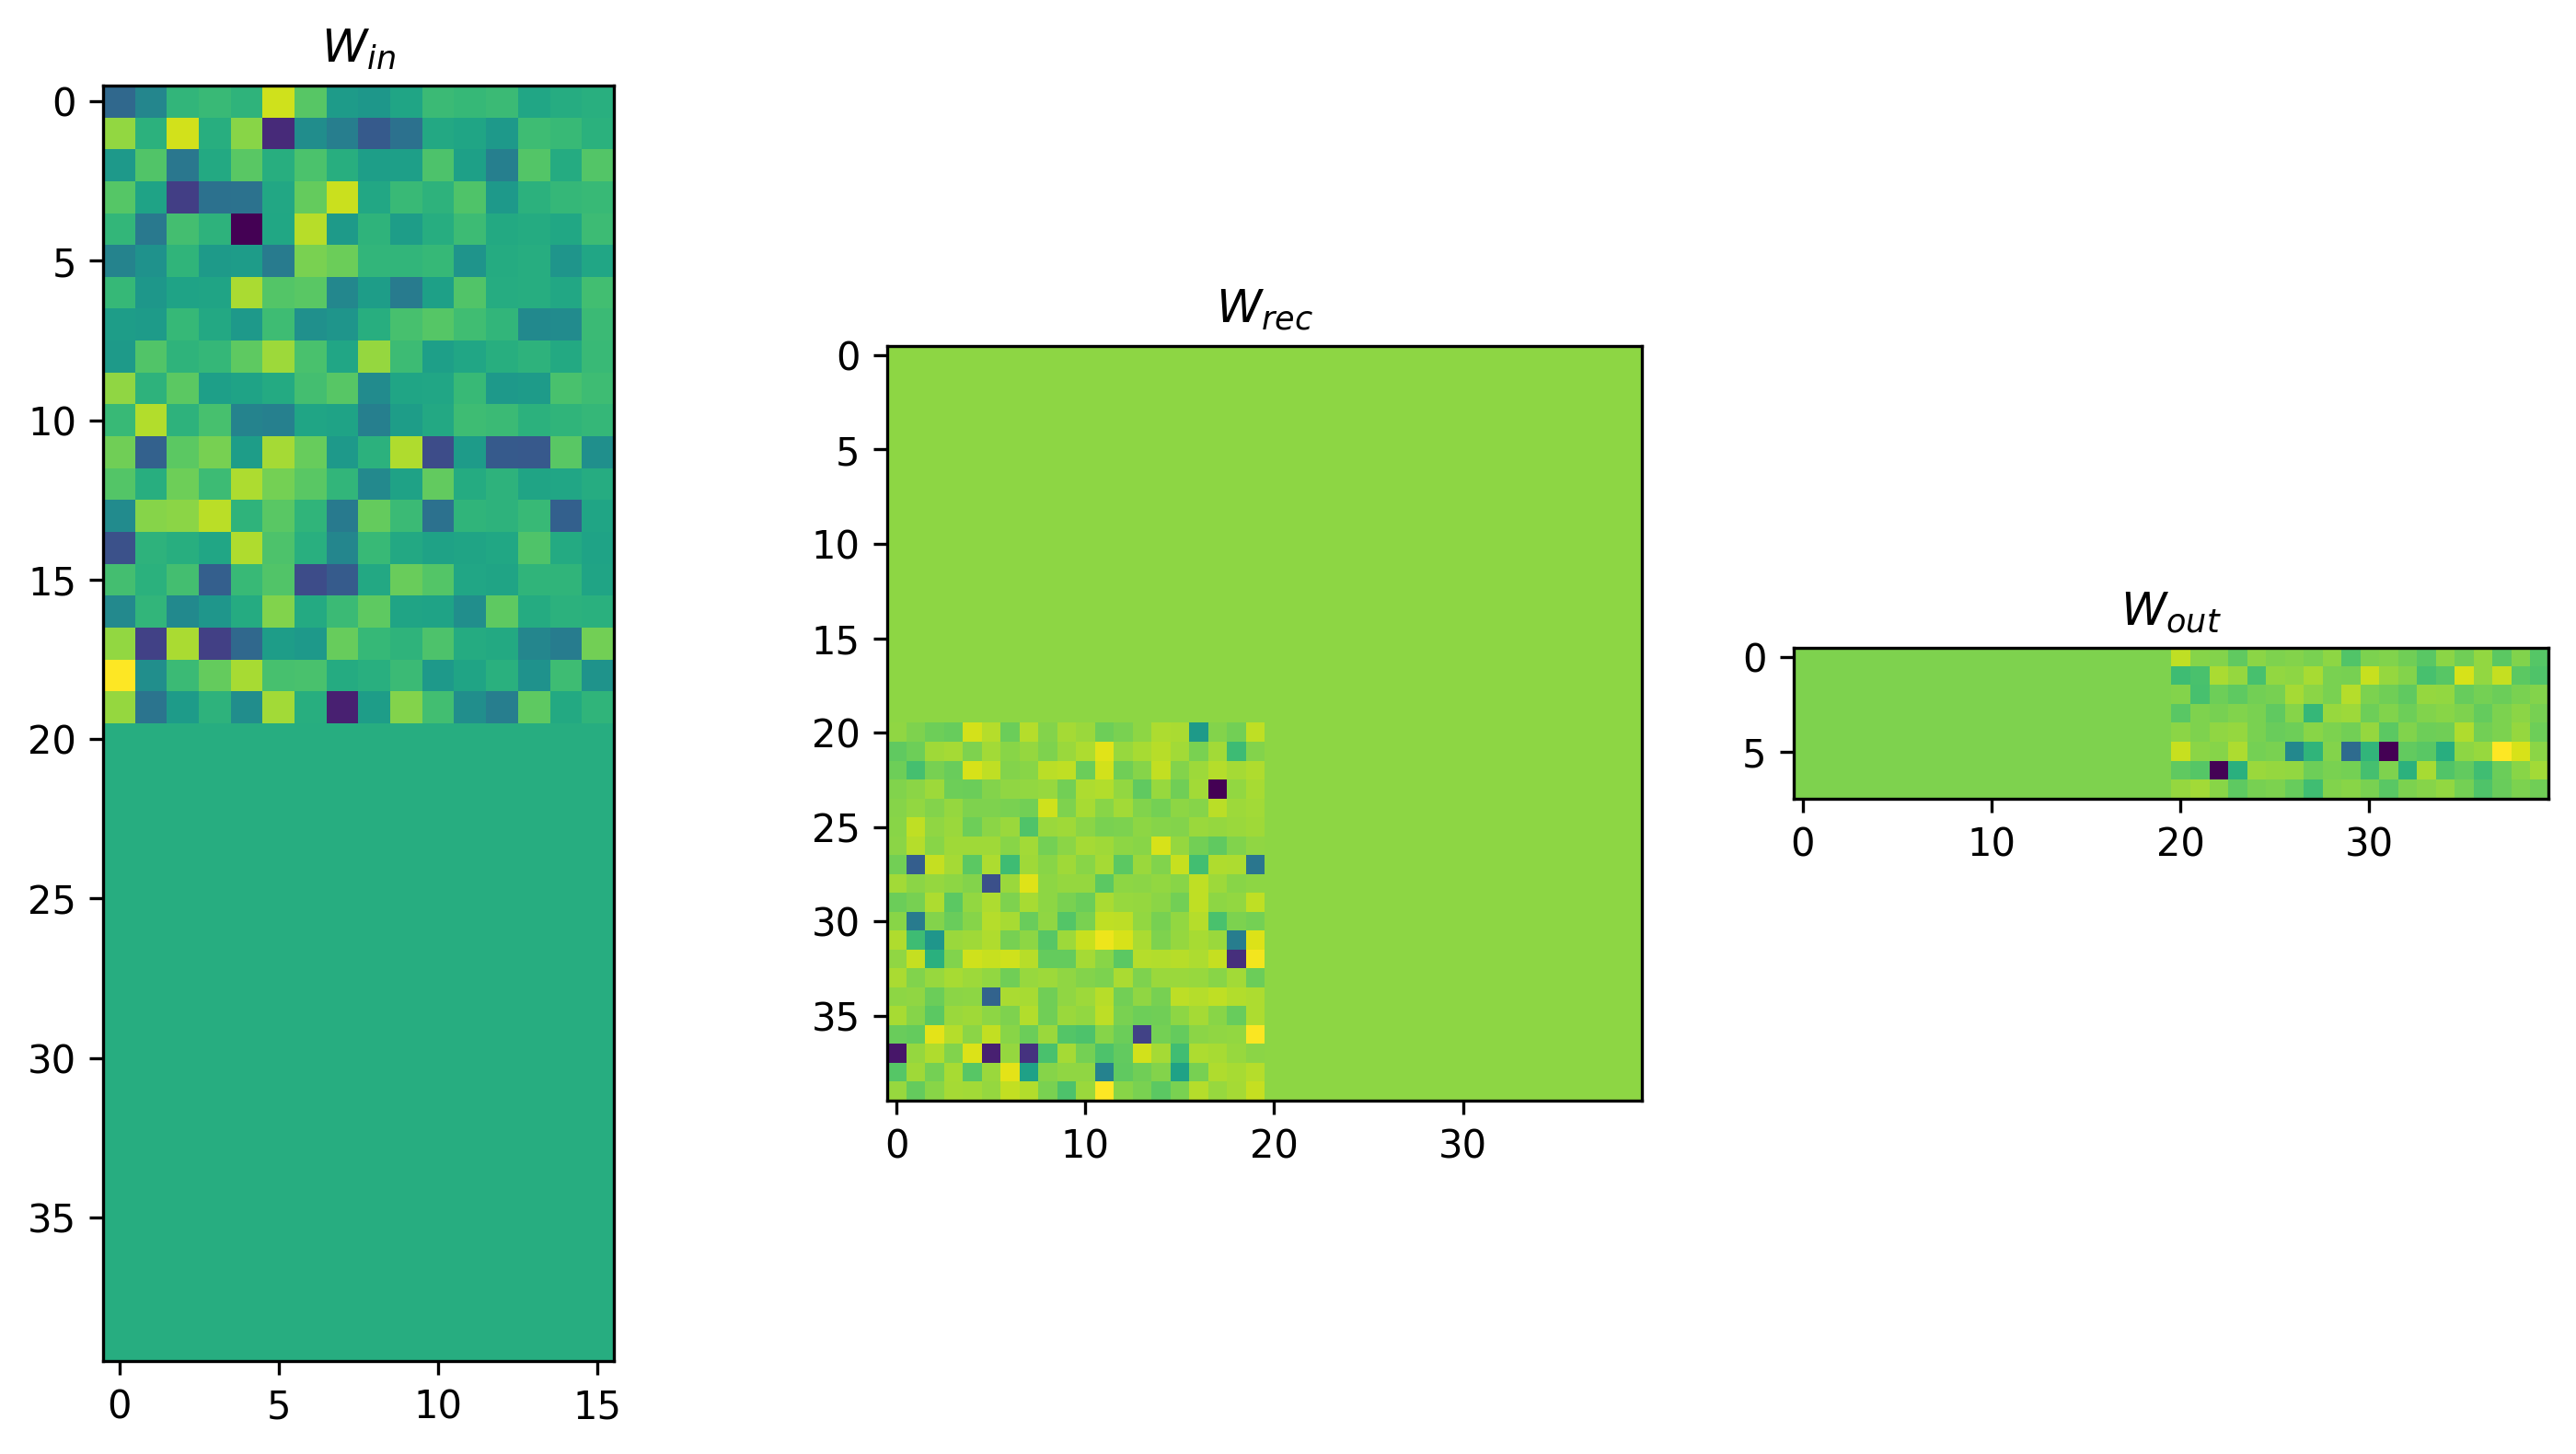

In [38]:
# - Let's look at the mapped weights
plt.subplot(1, 3, 1)
plt.imshow(spec['weights_in'].T)
plt.title('$W_{in}$')

plt.subplot(1, 3, 2)
plt.imshow(spec['weights_rec'].T)
plt.title('$W_{rec}$')

plt.subplot(1, 3, 3)
plt.imshow(spec['weights_out'].T)
plt.title('$W_{out}$');

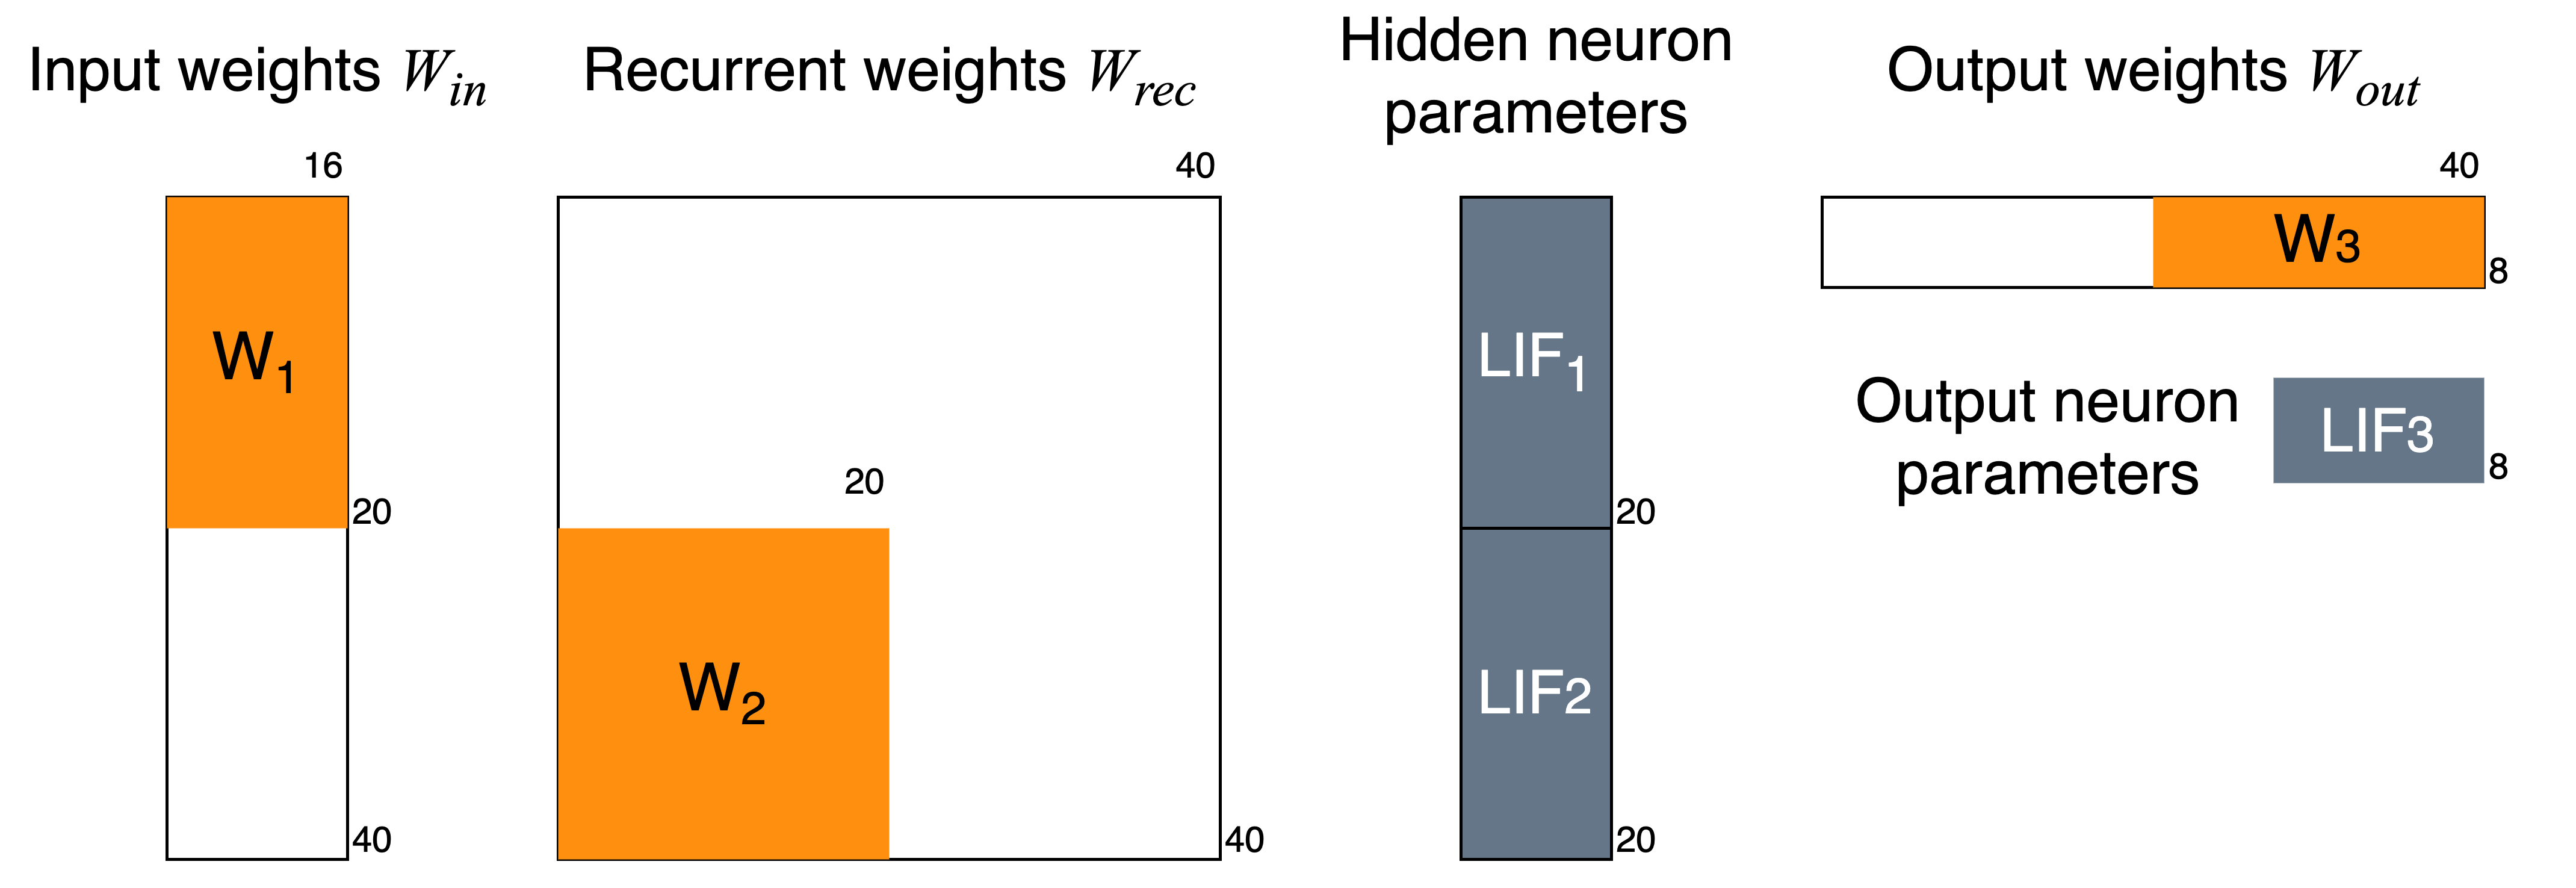

In [39]:
# - Compare this against our assumed solution from before
Image('images/mapped-weights.svg.png')

In [40]:
# - Import the PTQ quantization mini-library
from rockpool.transform.quantize_methods import channel_quantize

# - Quantise the parameters
spec_Q = spec
spec_Q.update(channel_quantize(**spec))

In [41]:
# - Convert to a HW configuration bitstream
config, is_valid, _ = xylo.config_from_specification(**spec_Q)
print(config)

xyloCore2::configuration::XyloConfiguration(operation_mode=OperationMode.Manual, synapse2_enable=0, bias_enable=1, 
direct_fetch_state_ram=0, enable_hibernation_mode=0, clear_network_state=0, time_resolution_wrap=0, 
hibernation_mode_time_resolution_wrap=0, input=xyloCore2::configuration::InputConfig(weight_bit_shift=0, weights={ 
-118 54 -45 32 8 -108 23 -57 -44 127 25 52 55 -56 -127 26 -104 63 127 52 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
-67 5 59 -12 -44 -69 -47 -64 58 14 127 -102 1 78 7 5 22 -126 -43 -57 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 78 
-127 -127 16 19 -23 40 15 76 11 40 79 81 2 25 -99 73 20 -17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 23 1 -9 -72 5 
-48 -20 -17 24 -35 42 56 31 110 -11 -104 -67 -127 48 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 11 50 67 -71 -127 
-42 127 -70 70 -26 -87 -22 127 11 87 17 -5 -83 83 -31 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 127 -127 3 -6 -5 -127
56 56 127 -7 -91 78 84 48 33 35 127 -19 28 56 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 48 -34 52 41 55 108 62 -103 
49 46 -18 47 60 12 2 -127 -8 -24 30 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -30 -49 2 85 -16 94 -81 -86 -17 71 
-22 -28 18 -84 -56 -109 39 43 -3 -127 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -38 -86 -35 -7 6 23 -34 5 120 -86 -93
6 -77 56 17 -6 85 13 3 -16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -15 -63 -34 16 -13 21 -104 72 34 -21 -33 84 -23 
24 -6 47 -25 8 19 46 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 -5 54 6 0 29 -27 96 -33 -19 -9 -127 69 -100 -16 36 
-30 29 -29 18 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 19 -8 -30 29 13 -65 54 59 -18 30 32 -24 -4 13 -14 -10 -88 -3 
-13 -31 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 -21 -107 -24 -3 -4 -1 29 2 -49 28 -111 11 9 -10 -13 87 -4 4 -47 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -12 17 61 6 -2 0 0 -127 13 -44 9 -112 -19 21 35 10 -5 -48 -38 30 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -2 12 -4 13 -5 -63 -11 -119 -8 54 16 39 -17 -127 -4 9 13 -60 23 -4 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 3 4 61 15 12 -20 37 51 30 39 20 -41 -2 -14 -15 -13 7 49 -37 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 }, syn2_weights={ 0 }), reservoir=xyloCore2::configuration::ReservoirConfig(weight_bit_shift=0, weights={ 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 -65 -52 -3 -16 -11 -9 -11 7 -84 -3 15 1 92 0 58 -12 -127 -31 12 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 -11 -47 -127 -1 10 88 68 -127 -1 -54 -127 -45 14 -48 1 -21 -14 1 9 -52 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 -24 23 -36 3 -22 1 -9 19 2 68 -5 -95 -36 31 -14 -127 25 8 -13 -6 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 -29 28 -60 -8 14 23 30 8 -1 -127 -18 6 -4 85 -1 26 11 -4 12 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 47 -21 106 -8 -32 -65 32 -19 -4 8 -4 8 18 47 -1 39 -1 19 -30 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 26 25 72 
-2 -31 -8 31 11 -127 67 18 15 16 16 -127 -4 16 -122 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -25 -7 -18 1 -43 21
-10 -33 4 -37 12 -12 18 -108 10 -35 -2 2 42 56 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 26 7 -9 1 -60 -127 36 6 25 
57 -19 0 11 29 10 80 -12 -113 -85 39 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -8 -22 64 2 127 23 -48 -2 -1 -1 1 -29 
-13 49 -12 -71 4 -19 -4 -24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 71 -7 -34 33 -5 6 2 -47 -30 7 -12 7 1 28 
-20 6 0 -84 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 39 -54 7 47 -5 41 -2 2 -87 -10 26 6 -36 6 11 -22 -7 1 12 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -23 108 99 8 -15 -40 [1;3

In [42]:
# - Create an HDK simulator module from the bitstream
mod = xylo.XyloSim.from_config(config, dt = net_dt)
print(mod)

XyloSim  with shape (16, 1000, 8)

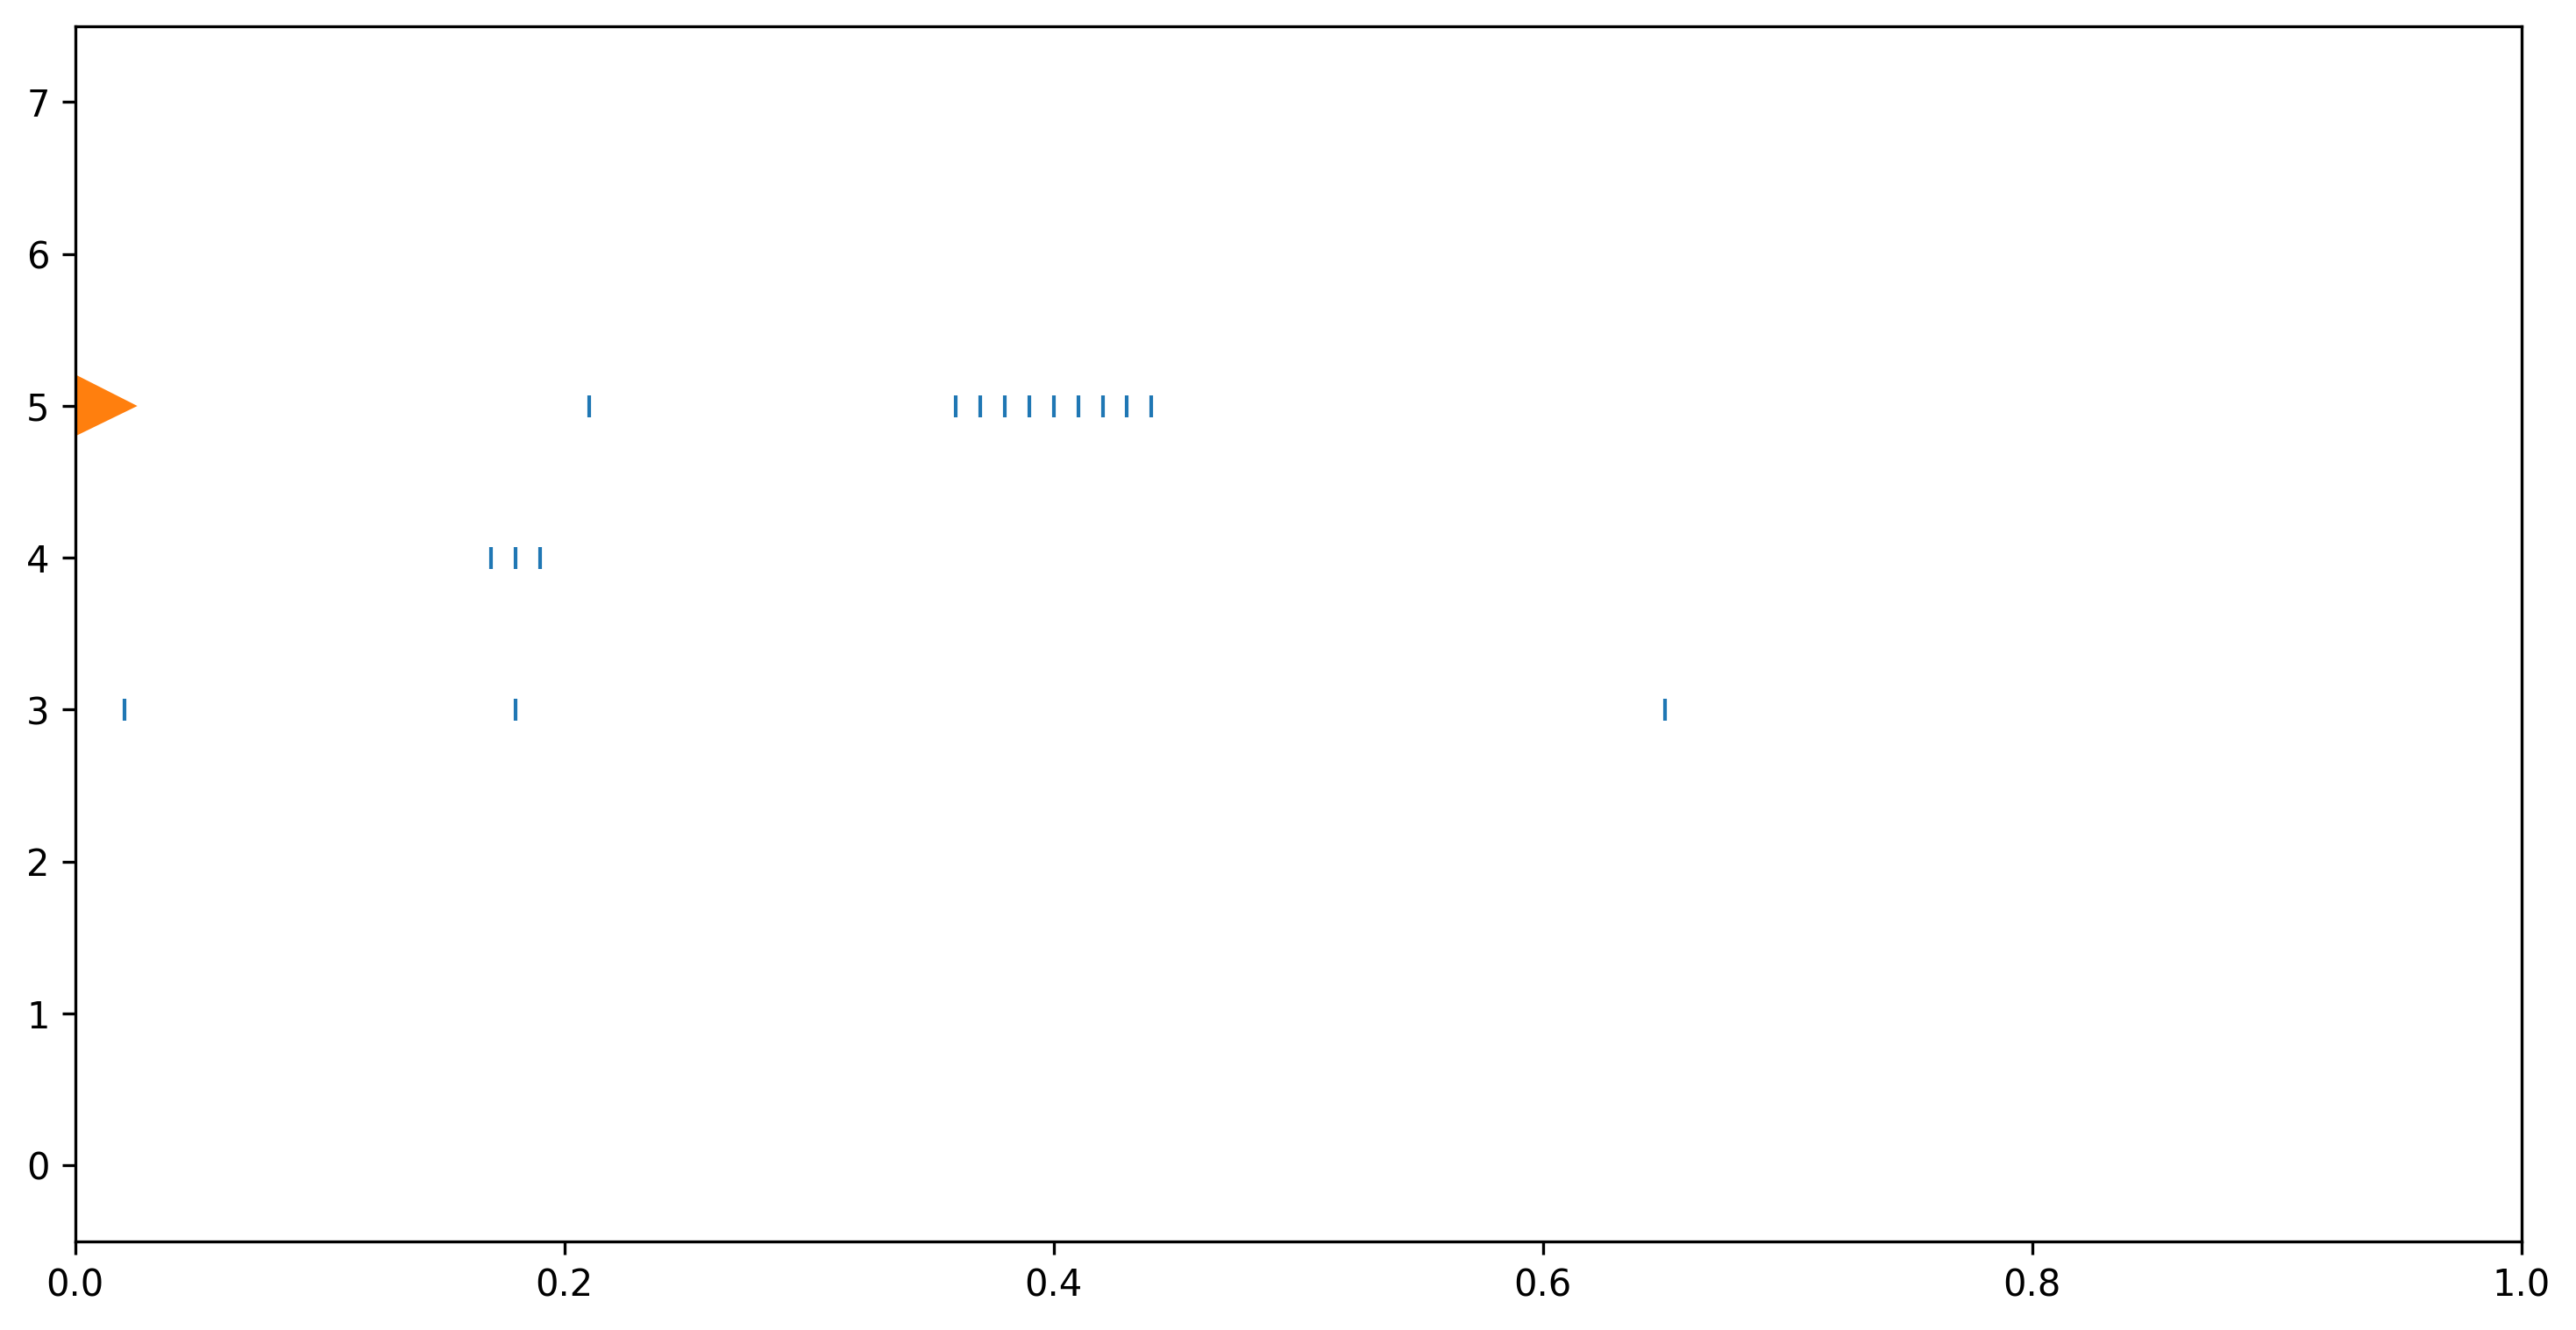

In [43]:
# - Let's look at the output of the simulated HDK on a training sample
events, label = train_data[2]
out_xsim, _, rd_xsim = mod(events.numpy(), record = True)
times, channels = np.nonzero(out_xsim)
plt.plot(times * net_dt, channels, '|')
plt.plot(0.01, label, '>', ms=18)
plt.ylim([-0.5, 7.5])
plt.xlim([0, 1.]);

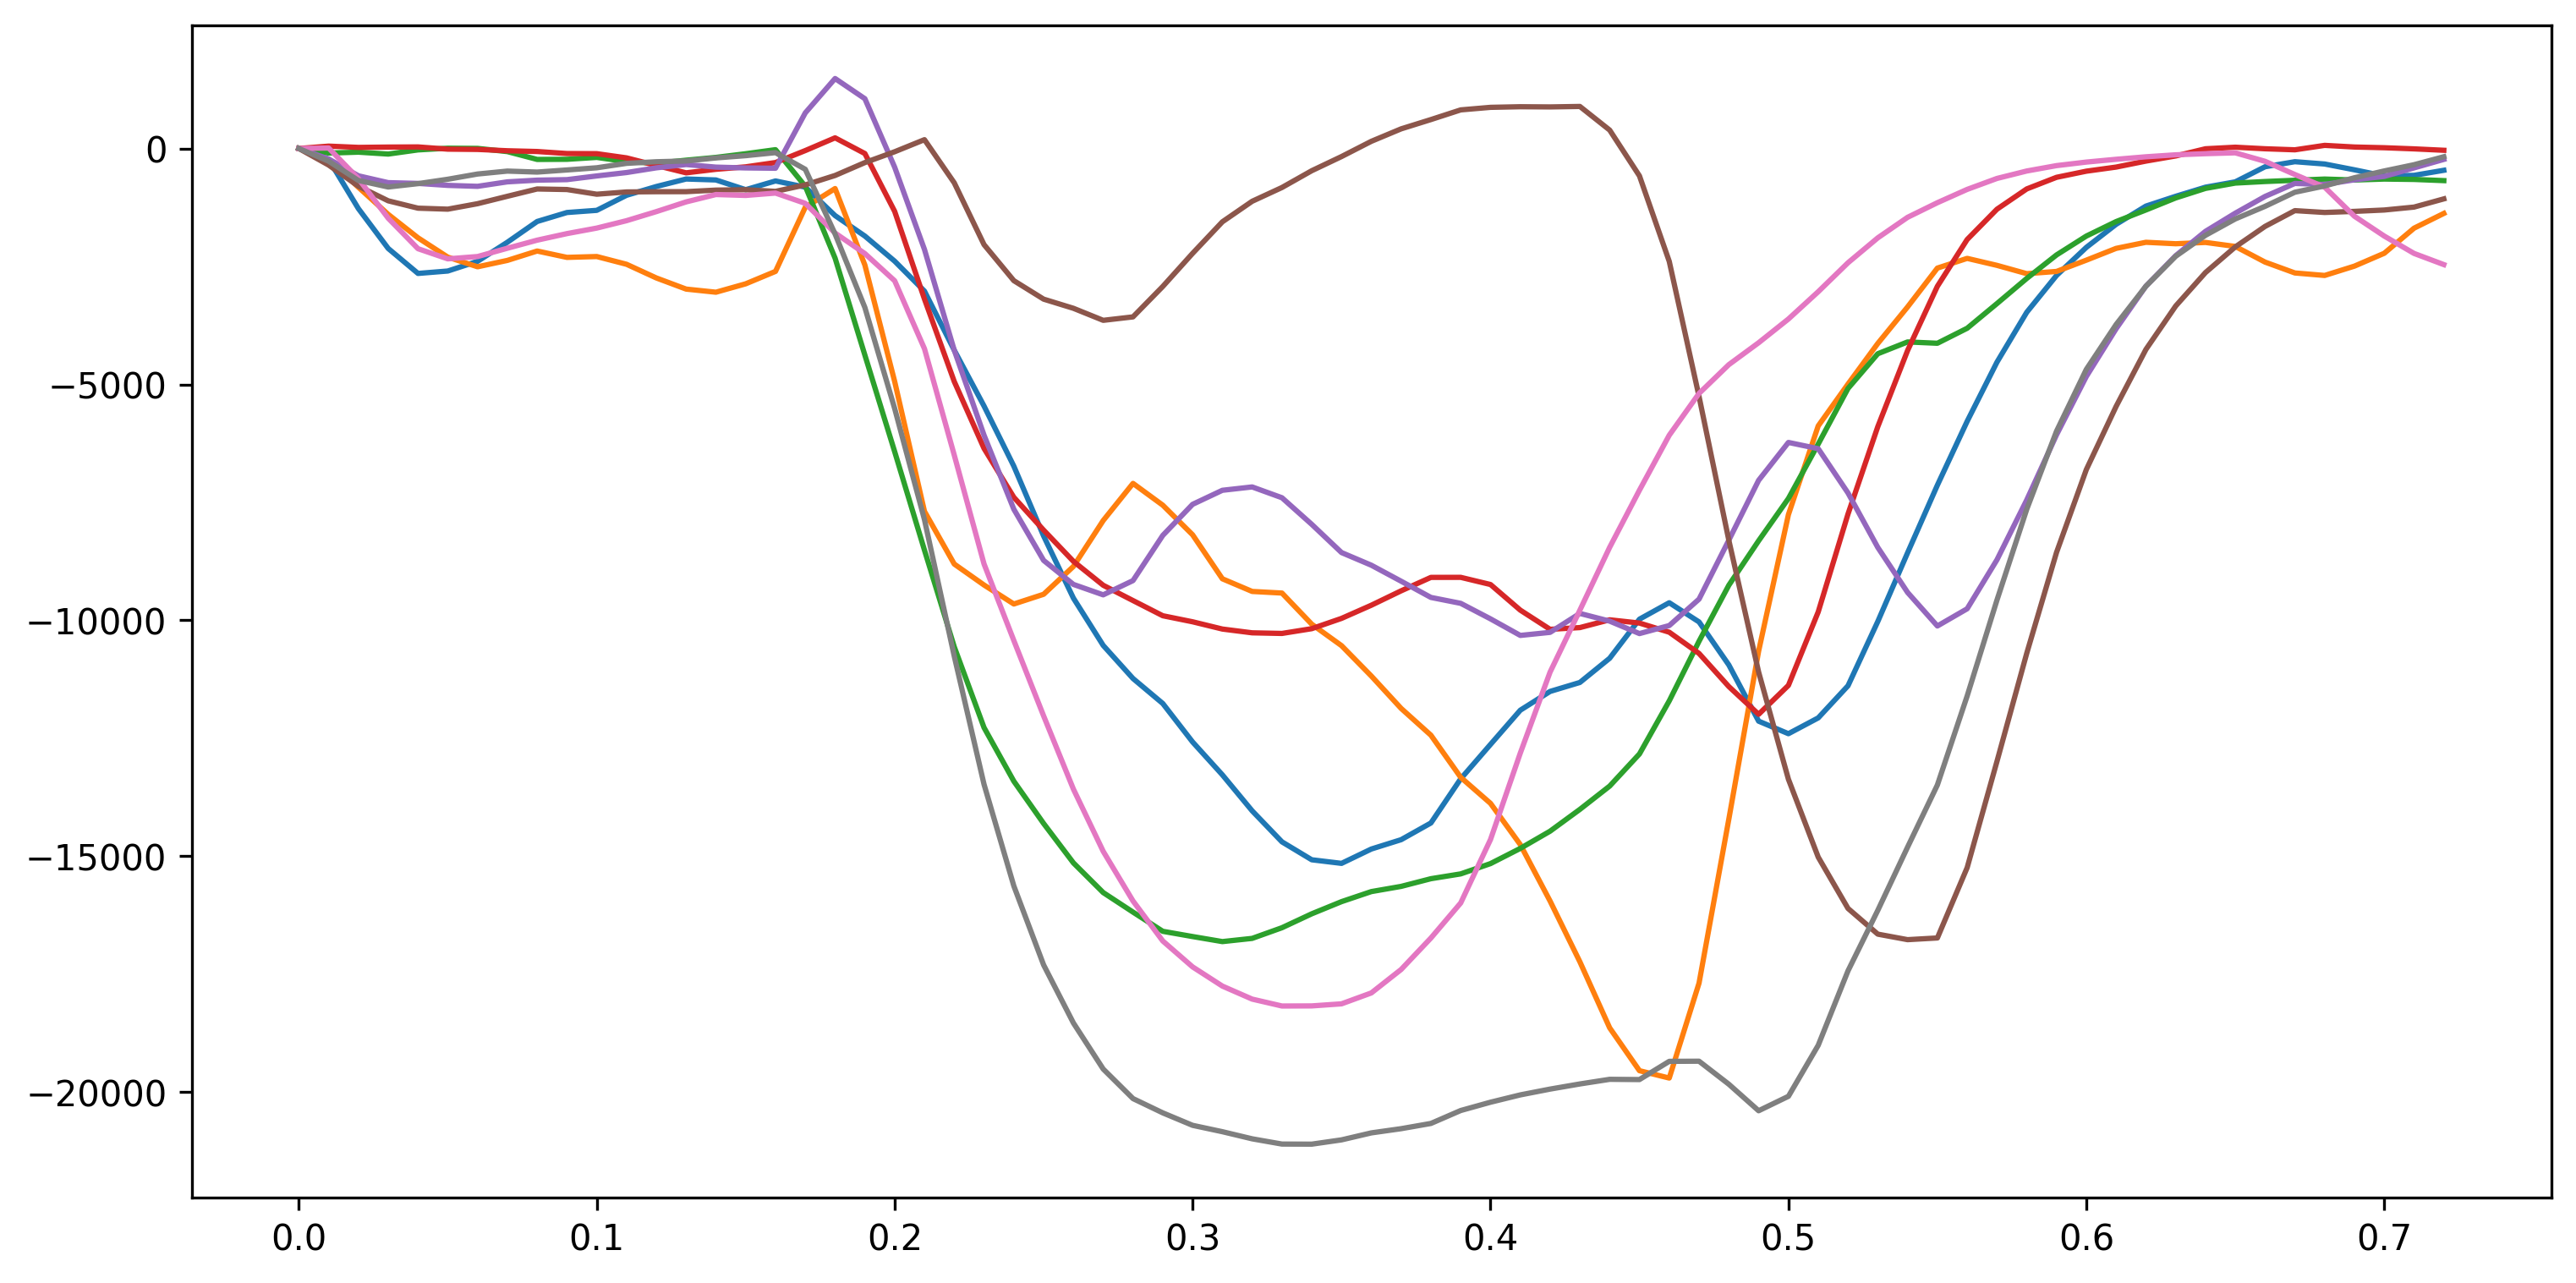

In [44]:
# - Let's plot the membrane potential of the output neurons
times = np.arange(out_xsim.shape[0]) * net_dt
plt.plot(times, rd_xsim['Vmem_out']);

In [45]:
# - Import the helper function to connect to a Xylo HDK
from rockpool.devices.xylo import find_xylo_hdks

In [46]:
# - Locate an HDK, if one is available
hdks, _, _ = find_xylo_hdks()
print(hdks)

assert len(hdks) > 0, 'The rest of this notebook needs a connected Xylo HDK.'

The connected Xylo HDK contains a Xylo Audio v2 (SYNS61201). Importing `rockpool.devices.xylo.syns61201`


[<samna.xyloA2TestBoard.XyloA2TestBoard object at 0x2d02cec30>]

In [47]:
# - We'll use the first connected HDK
hdk = hdks[0]

In [48]:
# - Now we can create a Rockpool module that wraps the HDK, by providing the configuration bitstream as before
mod_hdk = xylo.XyloSamna(hdk, config, net_dt)
print(mod_hdk)

XyloSamna  with shape (16, 40, 8)

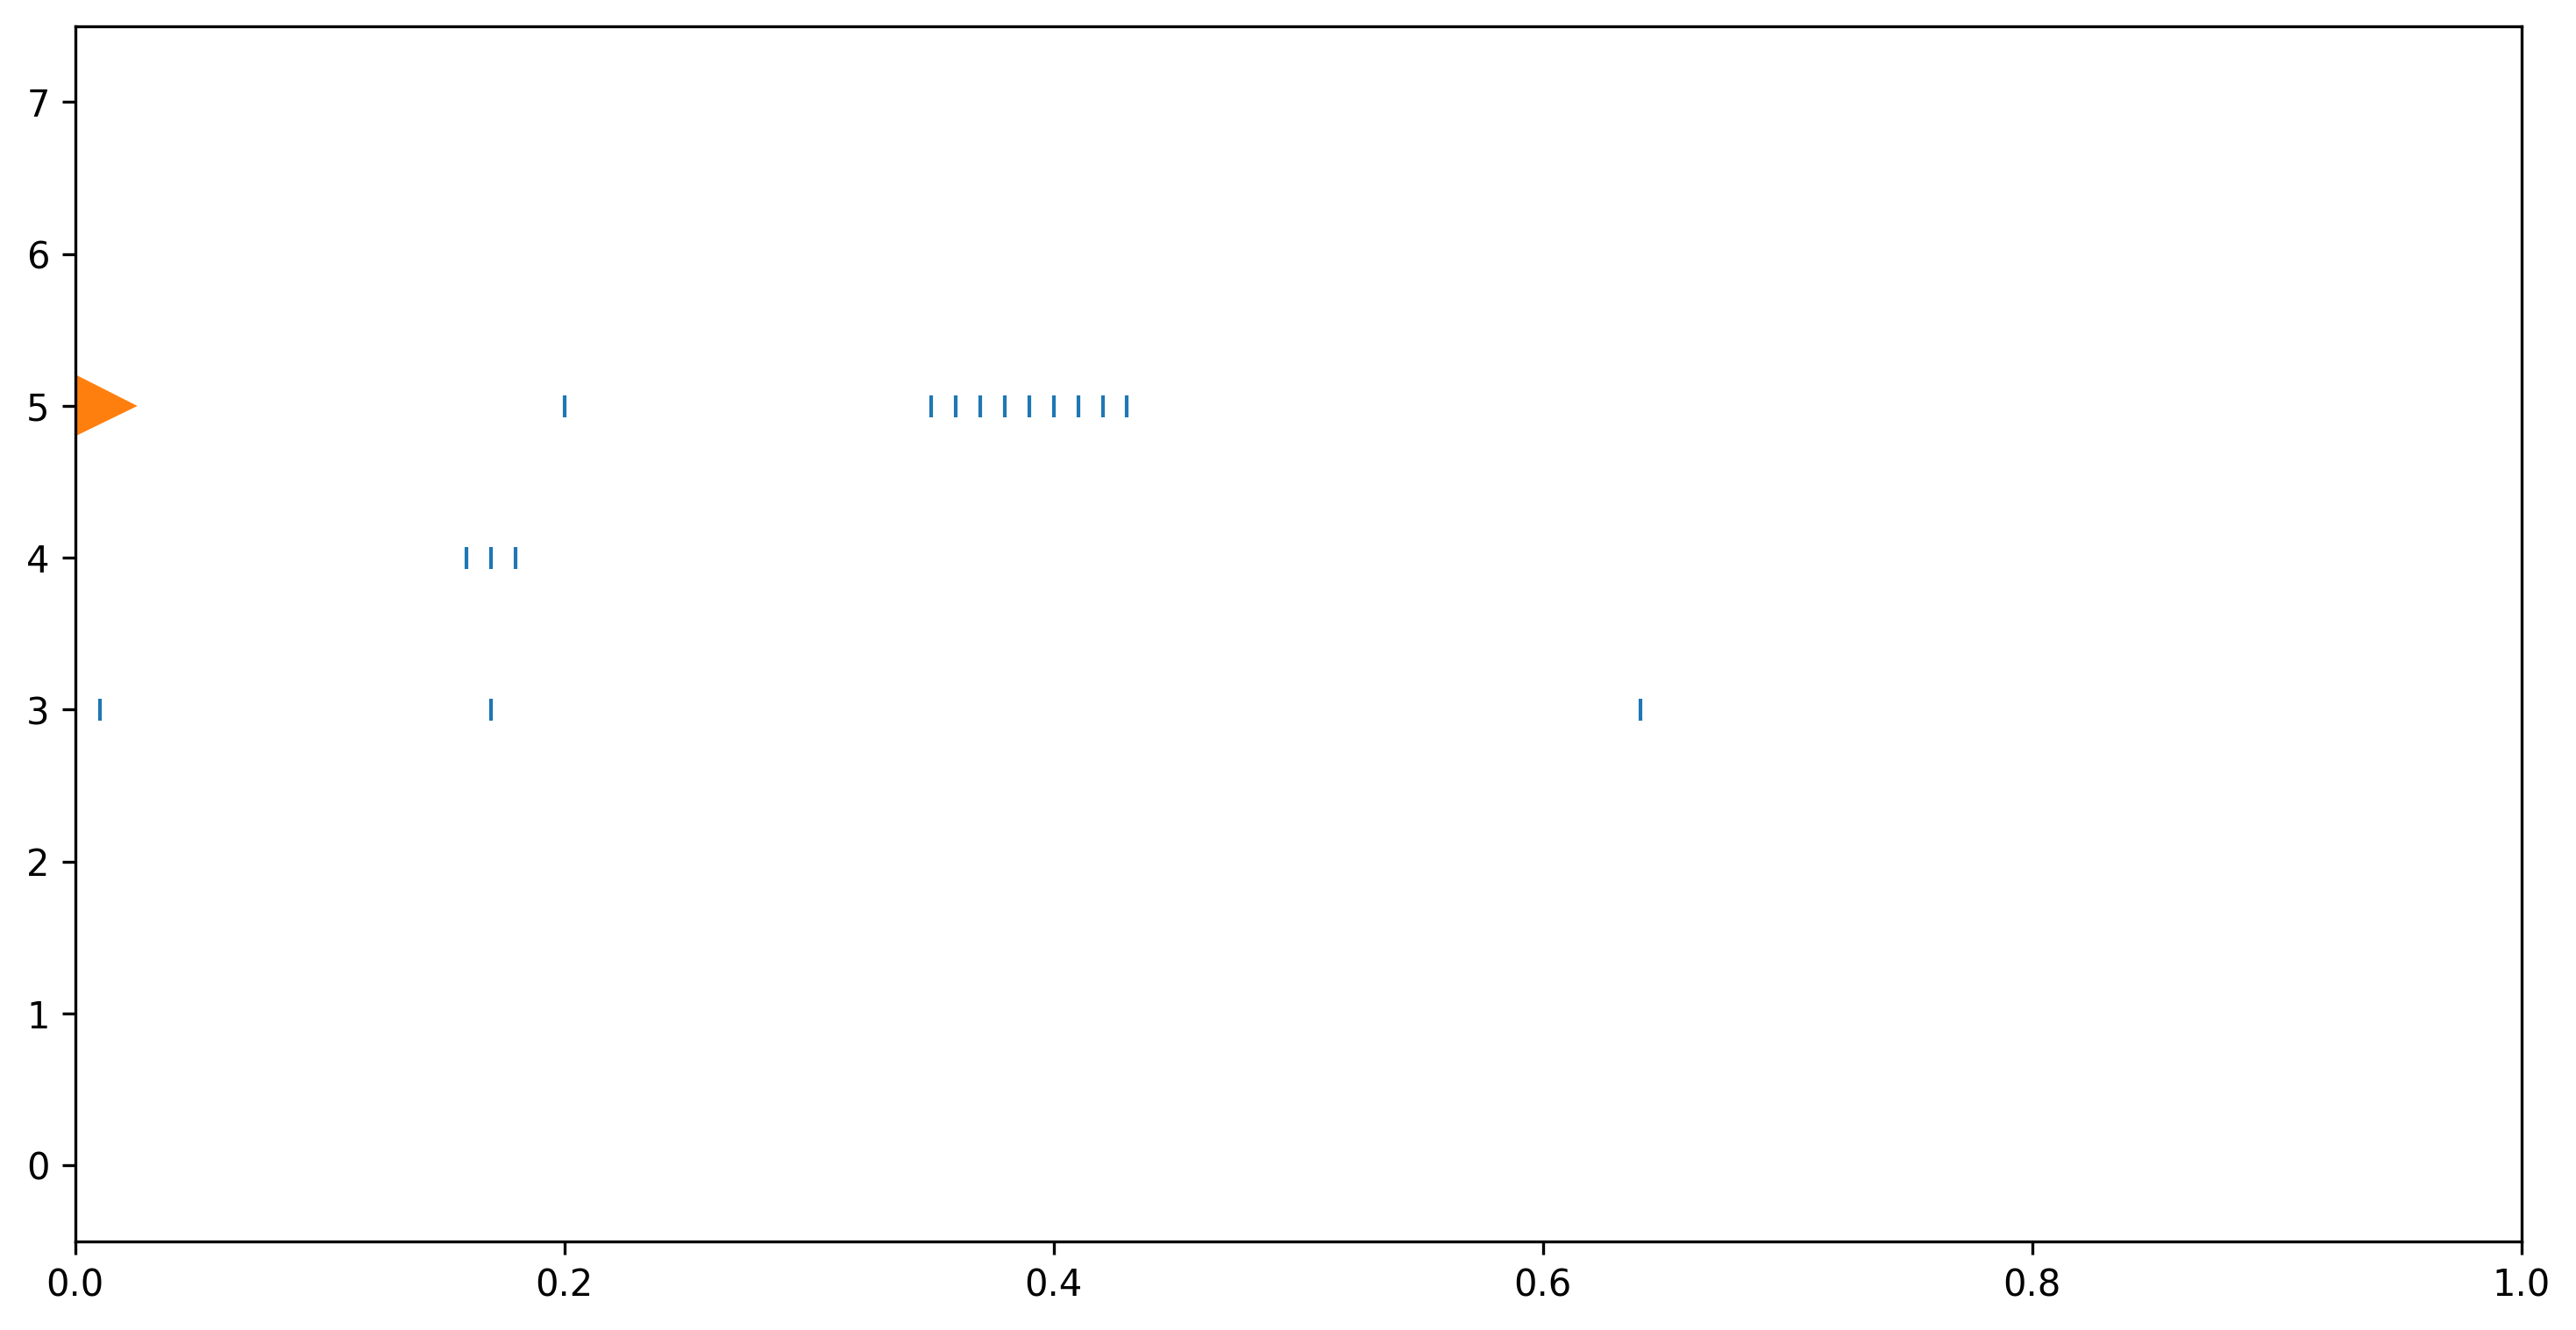

In [49]:
# - Evolve with a single training sample
events, label = train_data[2]
out_xhdk, _, rd_xhdk = mod_hdk(events.numpy().astype(int), record = True)

# - Plot the output
times, channels = np.nonzero(out_xhdk)
plt.plot(times * net_dt, channels, '|')
plt.plot(0.01, label, '>', ms=18)
plt.ylim([-0.5, 7.5])
plt.xlim([0, 1.]);

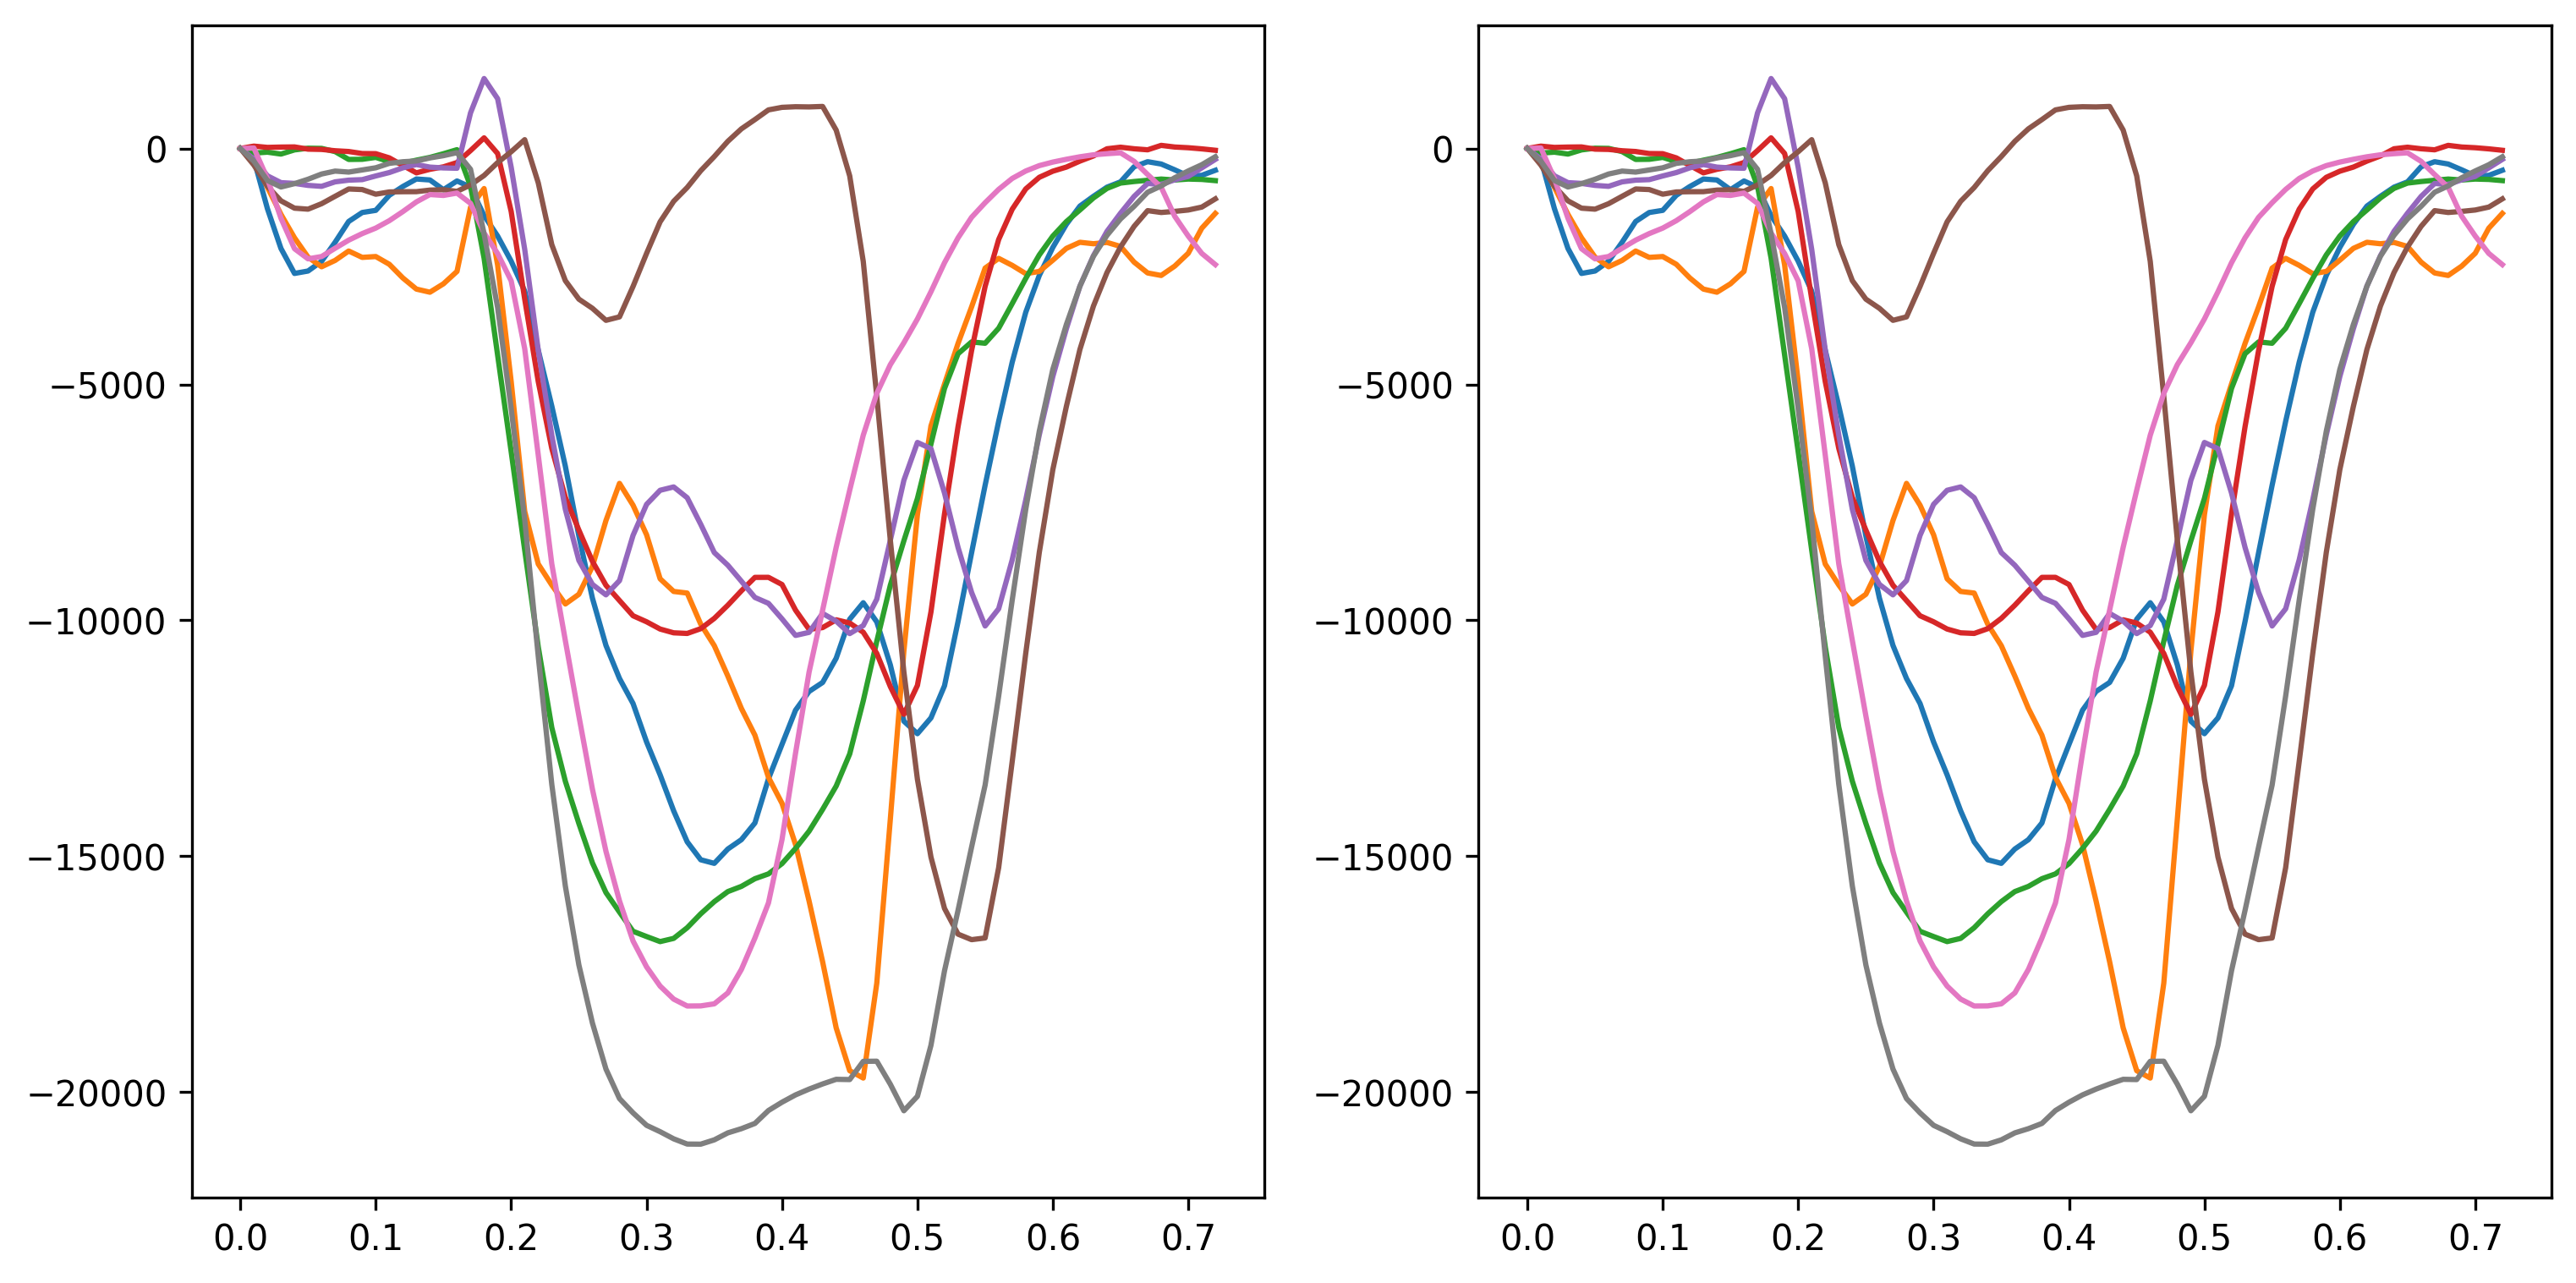

In [50]:
# - Let's compare the output Vmem between the HDK and the simulator
times = np.arange(out_xhdk.shape[0]) * net_dt
plt.subplot(1, 2, 1)
plt.plot(times, rd_xhdk['Vmem_out'])
plt.subplot(1, 2, 2)
plt.plot(times, rd_xsim['Vmem_out']);

In [51]:
# - We can also record real-time power consumption from the HDK during evolution
out_xhdk, _, rd_xhdk = mod_hdk(events.numpy().astype(int), record = True, record_power = True)

print(f'Power measurement: {np.mean(rd_xhdk["io_power"]) * 1e6:.2f} muW')

Power measurement: 238.13 muW

## Next steps
Check out further tutorials and documenation on (https://rockpool.ai)!

For more information about Xylo™, see (https://rockpool.ai/devices/xylo-overview.html)

For information about the Xylo™ HDK, see (https://www.synsense.ai/products/xylo/)

For a more in-depth published example, see (https://ieeexplore.ieee.org/document/9967462)(https://doi.org/10.48550/arXiv.2208.12991)